In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cholesky
from numpy.random import normal
# For Portfolio Optimization and Monte Carlo VaR
from scipy.optimize import minimize

In [35]:
import os
# Assuming the directory 'nifty_50_csv' contains the CSV files for each NIFTY 50 stock
data_path = 'C:/Users/sohan/OneDrive/Desktop/ACADEMICS/SEM 5/Probabilistic Reasoning/stocks project/NIFTY50_data_20240901_121017'
stock_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
# Create a dictionary to store stock data
stock_data = {}
# Load each CSV file
for stock_file in stock_files:
    stock_name = stock_file.split('.')[0]  # Assuming stock name is the filename
    stock_data[stock_name] = pd.read_csv(os.path.join(data_path, stock_file))

close_prices = pd.DataFrame()
for stock, df in stock_data.items():
    close_prices[stock] = df['Close']

**Daily Returns of Different sectors**

In [66]:
import pandas as pd
import os
data_path = 'C:/Users/sohan/OneDrive/Desktop/ACADEMICS/SEM 5/Probabilistic Reasoning/stocks project/NIFTY50_data_20240901_121017'

stock_files = os.listdir(data_path)
stock_data = {}

for stock_file in stock_files:
    stock_name = stock_file.split('.')[0]  # Assuming stock name is the filename
    stock_data[stock_name] = pd.read_csv(os.path.join(data_path, stock_file))

close_prices = pd.DataFrame()

for stock_name, data in stock_data.items():
    if 'Close' in data.columns:
        close_prices[stock_name] = data['Close']

# Fill missing values (if any)
close_prices = close_prices.ffill()  # Updated method to ffill()

# Calculate daily returns (percentage changes)
returns = close_prices.pct_change(fill_method=None).dropna()

# Print the available stock names in the returns DataFrame
print("Available Stock Names in Returns DataFrame:")
print(returns.columns)

# Define sectors and the corresponding stocks (with _data suffix)
sectors = {
    "Financial Services": ["AXISBANK_data", "BAJFINANCE_data", "HDFCBANK_data", "HDFCLIFE_data", "ICICIBANK_data", "INDUSINDBK_data", "KOTAKBANK_data", "SHRIRAMFIN_data", "SBIN_data", "SBILIFE_data", "BAJFINSV_data"],
    "Information Technology": ["INFY_data", "TCS_data", "WIPRO_data", "TECHM_data", "HCLTECH_data", "LT_data"],
    "Automobile and Auto Components": ["TATAMOTORS_data", "BAJAJ-AUTO_data", "EICHERMOT_data", "M&M_data", "HEROMOTOCO_data", "MARUTI_data"],
    "FMCG": ["ITC_data", "BRITANNIA_data", "HINDUNILVR_data", "NESTLEIND_data", "TATACONSUM_data"],
    "Healthcare": ["APOLLOHOSP_data", "CIPLA_data", "DIVISLAB_data", "DRREDDY_data", "SUNPHARMA_data"],
    "Oil Gas & Consumable Fuels": ["BPCL_data", "COALINDIA_data", "ONGC_data", "RELIANCE_data"],
    "Metals and Mining": ["ADANIENT_data", "HINDALCO_data", "JSWSTEEL_data", "TATASTEEL_data"],
    "Construction": ["ULTRACEMCO_data", "GRASIM_data", "LT_data"],
    "Power": ["NTPC_data", "POWERGRID_data"],
    "Consumer Durables": ["TITAN_data", "ASIANPAINT_data"],
    "Services": ["ADANIPORTS_data"],
    "Telecommunication": ["BHARTIARTL_data"]
}

# Dictionary to store sector returns
sector_returns = {}

# Calculate average daily returns for each sector
for sector, stocks in sectors.items():
    # Filter the stocks that exist in the returns DataFrame
    valid_stocks = [stock for stock in stocks if stock in returns.columns]
    
    if valid_stocks:
        # Filter the returns DataFrame to only include stocks in this sector
        sector_returns_df = returns[valid_stocks].mean(axis=1)  # Calculate the average return across the sector
        sector_returns[sector] = sector_returns_df
    else:
        print(f"No valid stocks found for sector: {sector}")

# Convert sector returns dictionary to DataFrame for easier visualization
sector_returns_df = pd.DataFrame(sector_returns)

# Print the sector returns DataFrame
print("Sector-wise Daily Returns:")
print(sector_returns_df)


Available Stock Names in Returns DataFrame:
Index(['ADANIENT_data', 'ADANIPORTS_data', 'APOLLOHOSP_data',
       'ASIANPAINT_data', 'AXISBANK_data', 'BAJAJ-AUTO_data',
       'BAJAJFINSV_data', 'BAJFINANCE_data', 'BHARTIARTL_data', 'BPCL_data',
       'BRITANNIA_data', 'CIPLA_data', 'COALINDIA_data', 'DIVISLAB_data',
       'DRREDDY_data', 'EICHERMOT_data', 'GRASIM_data', 'HCLTECH_data',
       'HDFCBANK_data', 'HDFCLIFE_data', 'HEROMOTOCO_data', 'HINDALCO_data',
       'HINDUNILVR_data', 'ICICIBANK_data', 'INDUSINDBK_data', 'INFY_data',
       'ITC_data', 'JSWSTEEL_data', 'KOTAKBANK_data', 'LT_data', 'M&M_data',
       'MARUTI_data', 'NESTLEIND_data', 'NIFTY50_all_stocks_data', 'NTPC_data',
       'ONGC_data', 'POWERGRID_data', 'RELIANCE_data', 'SBILIFE_data',
       'SBIN_data', 'SUNPHARMA_data', 'TATACONSUM_data', 'TATAMOTORS_data',
       'TATASTEEL_data', 'TCS_data', 'TECHM_data', 'TITAN_data',
       'ULTRACEMCO_data', 'UPL_data', 'WIPRO_data', 'ZEEL_data'],
      dtype='object')

**Portfolio Optimitsation-Markowitz Efficient Frontier**

In [33]:
# Step 3: Portfolio Optimization - Markowitz Efficient Frontier
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
    bounds = tuple((0, 1) for asset in range(num_assets))

    def minimize_variance(weights):
        return portfolio_variance(weights, cov_matrix)
    result = minimize(minimize_variance, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [45]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\sohan\anaconda3\lib\site-packages\mask_rcnn-2.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [49]:
from tabulate import tabulate

mean_returns_df_sorted = mean_returns_df.sort_values(by='Mean Returns', ascending=False)

print("Mean Returns in Decreasing Order (Pretty Table):")
print(tabulate(mean_returns_df_sorted, headers='keys', tablefmt='fancy_grid'))


Mean Returns in Decreasing Order (Pretty Table):
╒═════════════════════════╤════════════════╕
│                         │   Mean Returns │
╞═════════════════════════╪════════════════╡
│ CIPLA_data              │    0.00905267  │
├─────────────────────────┼────────────────┤
│ TATASTEEL_data          │    0.00459764  │
├─────────────────────────┼────────────────┤
│ BAJFINANCE_data         │    0.00329529  │
├─────────────────────────┼────────────────┤
│ EICHERMOT_data          │    0.00299385  │
├─────────────────────────┼────────────────┤
│ KOTAKBANK_data          │    0.00272638  │
├─────────────────────────┼────────────────┤
│ ADANIENT_data           │    0.00199995  │
├─────────────────────────┼────────────────┤
│ NIFTY50_all_stocks_data │    0.00199995  │
├─────────────────────────┼────────────────┤
│ GRASIM_data             │    0.00176223  │
├─────────────────────────┼────────────────┤
│ BPCL_data               │    0.00154484  │
├─────────────────────────┼────────────────┤
│ TITA

In [70]:
import pandas as pd
import os
from tabulate import tabulate

# Assuming data_path is set correctly
data_path = 'C:/Users/sohan/OneDrive/Desktop/ACADEMICS/SEM 5/Probabilistic Reasoning/stocks project/NIFTY50_data_20240901_121017'

# Load stock data from CSV files
stock_files = os.listdir(data_path)
stock_data = {}

for stock_file in stock_files:
    stock_name = stock_file.split('.')[0]  # Assuming stock name is the filename
    stock_data[stock_name] = pd.read_csv(os.path.join(data_path, stock_file))

# Combine closing prices for all stocks into a single DataFrame
close_prices = pd.DataFrame()

for stock_name, data in stock_data.items():
    if 'Close' in data.columns:
        close_prices[stock_name] = data['Close']

# Fill missing values (if any)
close_prices = close_prices.ffill()  # Updated method to ffill()

# Calculate daily returns (percentage changes)
returns = close_prices.pct_change(fill_method=None).dropna()

# Print the available stock names in the returns DataFrame
print("Available Stock Names in Returns DataFrame:")
print(returns.columns)

# Define sectors and the corresponding stocks (with _data suffix)
sectors = {
    "Financial Services": ["AXISBANK_data", "BAJFINANCE_data", "HDFCBANK_data", "HDFCLIFE_data", "ICICIBANK_data", "INDUSINDBK_data", "KOTAKBANK_data", "SHRIRAMFIN_data", "SBIN_data", "SBILIFE_data", "BAJFINSV_data"],
    "Information Technology": ["INFY_data", "TCS_data", "WIPRO_data", "TECHM_data", "HCLTECH_data", "LT_data"],
    "Automobile and Auto Components": ["TATAMOTORS_data", "BAJAJ-AUTO_data", "EICHERMOT_data", "M&M_data", "HEROMOTOCO_data", "MARUTI_data"],
    "FMCG": ["ITC_data", "BRITANNIA_data", "HINDUNILVR_data", "NESTLEIND_data", "TATACONSUM_data"],
    "Healthcare": ["APOLLOHOSP_data", "CIPLA_data", "DIVISLAB_data", "DRREDDY_data", "SUNPHARMA_data"],
    "Oil Gas & Consumable Fuels": ["BPCL_data", "COALINDIA_data", "ONGC_data", "RELIANCE_data"],
    "Metals and Mining": ["ADANIENT_data", "HINDALCO_data", "JSWSTEEL_data", "TATASTEEL_data"],
    "Construction": ["ULTRACEMCO_data", "GRASIM_data", "LT_data"],
    "Power": ["NTPC_data", "POWERGRID_data"],
    "Consumer Durables": ["TITAN_data", "ASIANPAINT_data"],
    "Services": ["ADANIPORTS_data"],
    "Telecommunication": ["BHARTIARTL_data"]
}

# Dictionary to store sector returns
sector_returns = {}

# Calculate average daily returns for each sector
for sector, stocks in sectors.items():
    # Filter the stocks that exist in the returns DataFrame
    valid_stocks = [stock for stock in stocks if stock in returns.columns]
    
    if valid_stocks:
        # Calculate the average return across the sector
        sector_returns_df = returns[valid_stocks].mean(axis=1)  # Average return for each day
        sector_returns[sector] = sector_returns_df
    else:
        print(f"No valid stocks found for sector: {sector}")

# Calculate mean returns for each sector
mean_returns = {sector: data.mean() for sector, data in sector_returns.items()}

# Create a list of tuples for tabulate
mean_returns_table = [(sector, mean_return) for sector, mean_return in mean_returns.items()]

# Print the mean returns using tabulate
print("\nMean Returns for Each Sector:")
print(tabulate(mean_returns_table, headers=["Sector", "Mean Daily Return"], tablefmt="pretty"))


Available Stock Names in Returns DataFrame:
Index(['ADANIENT_data', 'ADANIPORTS_data', 'APOLLOHOSP_data',
       'ASIANPAINT_data', 'AXISBANK_data', 'BAJAJ-AUTO_data',
       'BAJAJFINSV_data', 'BAJFINANCE_data', 'BHARTIARTL_data', 'BPCL_data',
       'BRITANNIA_data', 'CIPLA_data', 'COALINDIA_data', 'DIVISLAB_data',
       'DRREDDY_data', 'EICHERMOT_data', 'GRASIM_data', 'HCLTECH_data',
       'HDFCBANK_data', 'HDFCLIFE_data', 'HEROMOTOCO_data', 'HINDALCO_data',
       'HINDUNILVR_data', 'ICICIBANK_data', 'INDUSINDBK_data', 'INFY_data',
       'ITC_data', 'JSWSTEEL_data', 'KOTAKBANK_data', 'LT_data', 'M&M_data',
       'MARUTI_data', 'NESTLEIND_data', 'NIFTY50_all_stocks_data', 'NTPC_data',
       'ONGC_data', 'POWERGRID_data', 'RELIANCE_data', 'SBILIFE_data',
       'SBIN_data', 'SUNPHARMA_data', 'TATACONSUM_data', 'TATAMOTORS_data',
       'TATASTEEL_data', 'TCS_data', 'TECHM_data', 'TITAN_data',
       'ULTRACEMCO_data', 'UPL_data', 'WIPRO_data', 'ZEEL_data'],
      dtype='object')

Covariance Matrix for Sectors:
                                Financial Services  Information Technology  \
Financial Services                        0.000377                0.000008   
Information Technology                    0.000008                0.000143   
Automobile and Auto Components            0.000028                0.000019   
FMCG                                      0.000013                0.000014   
Healthcare                                0.000017                0.000017   
Oil Gas & Consumable Fuels                0.000028                0.000012   
Metals and Mining                         0.000025                0.000027   
Construction                              0.000392                0.000034   
Power                                    -0.000004               -0.000003   
Consumer Durables                         0.000029                0.000023   
Services                                  0.000003               -0.000002   
Telecommunication                

C:\Users\sohan\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
C:\Users\sohan\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


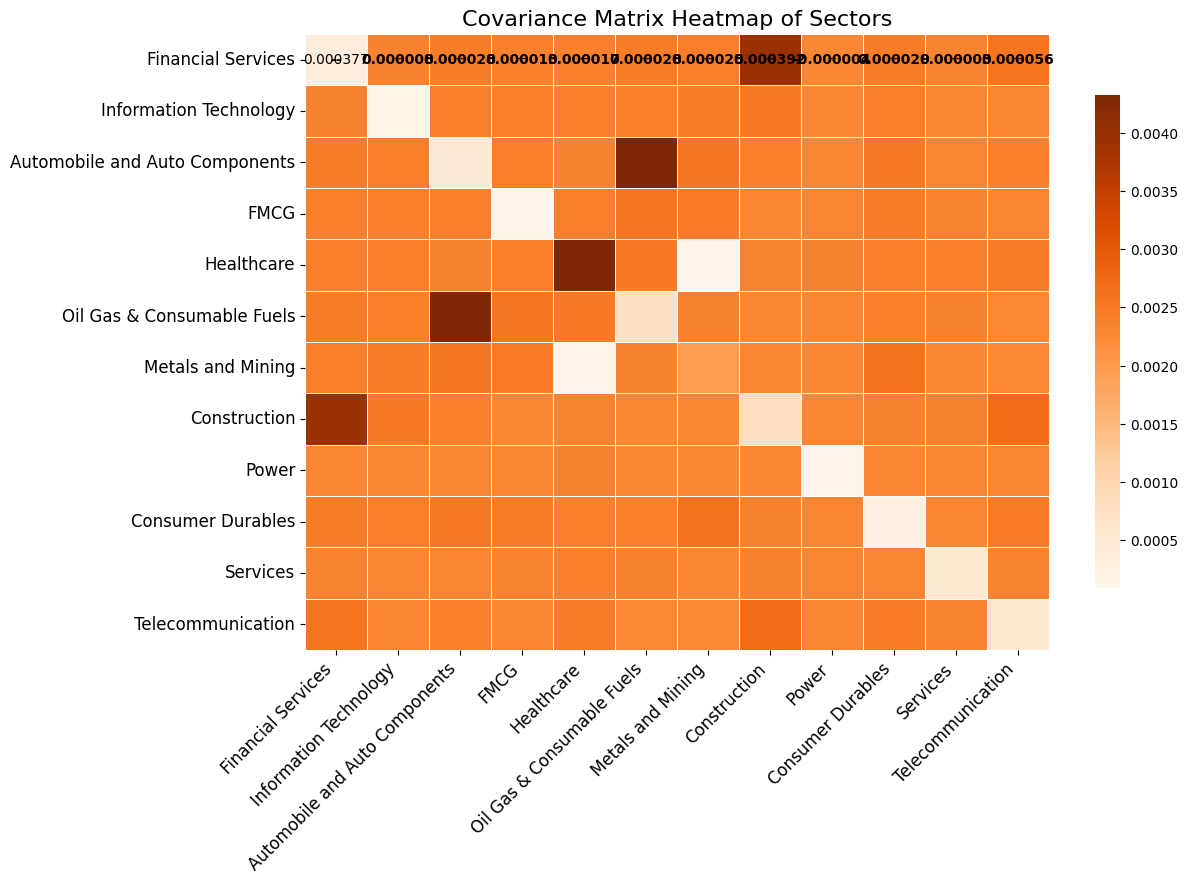

In [93]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming data_path is set correctly
data_path = 'C:/Users/sohan/OneDrive/Desktop/ACADEMICS/SEM 5/Probabilistic Reasoning/stocks project/NIFTY50_data_20240901_121017'

# Load stock data from CSV files
stock_files = os.listdir(data_path)
stock_data = {}

for stock_file in stock_files:
    stock_name = stock_file.split('.')[0]  # Assuming stock name is the filename
    stock_data[stock_name] = pd.read_csv(os.path.join(data_path, stock_file))

# Combine closing prices for all stocks into a single DataFrame
close_prices = pd.DataFrame()

for stock_name, data in stock_data.items():
    if 'Close' in data.columns:
        close_prices[stock_name] = data['Close']

# Fill missing values (if any)
close_prices = close_prices.ffill()  # Updated method to ffill()

# Calculate daily returns (percentage changes)
returns = close_prices.pct_change(fill_method=None).dropna()

# Define sectors and the corresponding stocks (with _data suffix)
sectors = {
    "Financial Services": ["AXISBANK_data", "BAJFINANCE_data", "HDFCBANK_data", "HDFCLIFE_data", "ICICIBANK_data", "INDUSINDBK_data", "KOTAKBANK_data", "SHRIRAMFIN_data", "SBIN_data", "SBILIFE_data", "BAJFINSV_data"],
    "Information Technology": ["INFY_data", "TCS_data", "WIPRO_data", "TECHM_data", "HCLTECH_data", "LT_data"],
    "Automobile and Auto Components": ["TATAMOTORS_data", "BAJAJ-AUTO_data", "EICHERMOT_data", "M&M_data", "HEROMOTOCO_data", "MARUTI_data"],
    "FMCG": ["ITC_data", "BRITANNIA_data", "HINDUNILVR_data", "NESTLEIND_data", "TATACONSUM_data"],
    "Healthcare": ["APOLLOHOSP_data", "CIPLA_data", "DIVISLAB_data", "DRREDDY_data", "SUNPHARMA_data"],
    "Oil Gas & Consumable Fuels": ["BPCL_data", "COALINDIA_data", "ONGC_data", "RELIANCE_data"],
    "Metals and Mining": ["ADANIENT_data", "HINDALCO_data", "JSWSTEEL_data", "TATASTEEL_data"],
    "Construction": ["ULTRACEMCO_data", "GRASIM_data", "LT_data"],
    "Power": ["NTPC_data", "POWERGRID_data"],
    "Consumer Durables": ["TITAN_data", "ASIANPAINT_data"],
    "Services": ["ADANIPORTS_data"],
    "Telecommunication": ["BHARTIARTL_data"]
}

# Calculate average daily returns for each sector
sector_returns = {}

for sector, stocks in sectors.items():
    # Filter valid stocks for the current sector
    valid_stocks = [stock for stock in stocks if stock in returns.columns]
    if valid_stocks:
        # Calculate the average return across the sector
        sector_returns[sector] = returns[valid_stocks].mean(axis=1)

# Convert the sector returns to a DataFrame
sector_returns_df = pd.DataFrame(sector_returns)

# Calculate covariance matrix for sector returns
cov_matrix_sectors = sector_returns_df.cov()

# Print covariance matrix
print("Covariance Matrix for Sectors:")
print(cov_matrix_sectors)

# Plot heatmap of covariance matrix for sectors
plt.figure(figsize=(12, 8))
mask = np.eye(cov_matrix_sectors.shape[0], dtype=bool)  # Create a mask for diagonal elements

# Set up the color palette
cmap = sns.color_palette("Oranges", as_cmap=True)

# Plot the heatmap
sns.heatmap(cov_matrix_sectors, annot=True, fmt=".6f", cmap=cmap, linewidths=0.5, 
            cbar_kws={"shrink": .8}, mask=~mask, annot_kws={"size": 10, "color": "black"})

# Overlay diagonal values with a different background color
sns.heatmap(cov_matrix_sectors, annot=True, fmt=".6f", cmap='Oranges', linewidths=0.5, 
            cbar=False, mask=mask, annot_kws={"size": 10, "color": "black", "weight": "bold"})

plt.title("Covariance Matrix Heatmap of Sectors", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Covariance Matrix for Sectors:
                                Financial Services  Information Technology  \
Financial Services                        0.000377                0.000008   
Information Technology                    0.000008                0.000143   
Automobile and Auto Components            0.000028                0.000019   
FMCG                                      0.000013                0.000014   
Healthcare                                0.000017                0.000017   
Oil Gas & Consumable Fuels                0.000028                0.000012   
Metals and Mining                         0.000025                0.000027   
Construction                              0.000392                0.000034   
Power                                    -0.000004               -0.000003   
Consumer Durables                         0.000029                0.000023   
Services                                  0.000003               -0.000002   
Telecommunication                

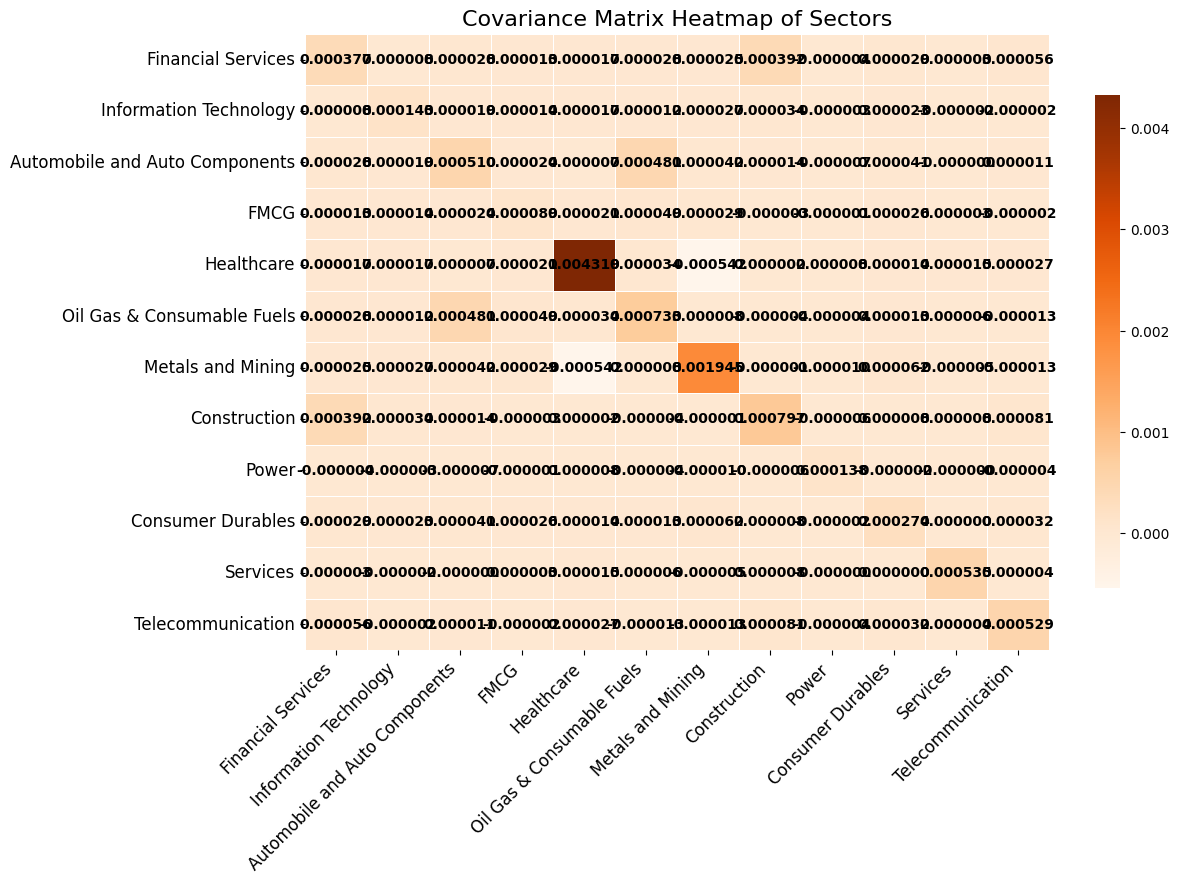

In [91]:
    import pandas as pd
    import os
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Assuming data_path is set correctly
    data_path = 'C:/Users/sohan/OneDrive/Desktop/ACADEMICS/SEM 5/Probabilistic Reasoning/stocks project/NIFTY50_data_20240901_121017'
    
    # Load stock data from CSV files
    stock_files = os.listdir(data_path)
    stock_data = {}
    
    for stock_file in stock_files:
        stock_name = stock_file.split('.')[0]  # Assuming stock name is the filename
        stock_data[stock_name] = pd.read_csv(os.path.join(data_path, stock_file))
    
    # Combine closing prices for all stocks into a single DataFrame
    close_prices = pd.DataFrame()
    
    for stock_name, data in stock_data.items():
        if 'Close' in data.columns:
            close_prices[stock_name] = data['Close']
    
    # Fill missing values (if any)
    close_prices = close_prices.ffill()  # Updated method to ffill()
    
    # Calculate daily returns (percentage changes)
    returns = close_prices.pct_change(fill_method=None).dropna()
    
    # Define sectors and the corresponding stocks (with _data suffix)
    sectors = {
        "Financial Services": ["AXISBANK_data", "BAJFINANCE_data", "HDFCBANK_data", "HDFCLIFE_data", "ICICIBANK_data", "INDUSINDBK_data", "KOTAKBANK_data", "SHRIRAMFIN_data", "SBIN_data", "SBILIFE_data", "BAJFINSV_data"],
        "Information Technology": ["INFY_data", "TCS_data", "WIPRO_data", "TECHM_data", "HCLTECH_data", "LT_data"],
        "Automobile and Auto Components": ["TATAMOTORS_data", "BAJAJ-AUTO_data", "EICHERMOT_data", "M&M_data", "HEROMOTOCO_data", "MARUTI_data"],
        "FMCG": ["ITC_data", "BRITANNIA_data", "HINDUNILVR_data", "NESTLEIND_data", "TATACONSUM_data"],
        "Healthcare": ["APOLLOHOSP_data", "CIPLA_data", "DIVISLAB_data", "DRREDDY_data", "SUNPHARMA_data"],
        "Oil Gas & Consumable Fuels": ["BPCL_data", "COALINDIA_data", "ONGC_data", "RELIANCE_data"],
        "Metals and Mining": ["ADANIENT_data", "HINDALCO_data", "JSWSTEEL_data", "TATASTEEL_data"],
        "Construction": ["ULTRACEMCO_data", "GRASIM_data", "LT_data"],
        "Power": ["NTPC_data", "POWERGRID_data"],
        "Consumer Durables": ["TITAN_data", "ASIANPAINT_data"],
        "Services": ["ADANIPORTS_data"],
        "Telecommunication": ["BHARTIARTL_data"]
    }
    
    # Calculate average daily returns for each sector
    sector_returns = {}
    
    for sector, stocks in sectors.items():
        # Filter valid stocks for the current sector
        valid_stocks = [stock for stock in stocks if stock in returns.columns]
        if valid_stocks:
            # Calculate the average return across the sector
            sector_returns[sector] = returns[valid_stocks].mean(axis=1)
    
    # Convert the sector returns to a DataFrame
    sector_returns_df = pd.DataFrame(sector_returns)
    
    # Calculate covariance matrix for sector returns
    cov_matrix_sectors = sector_returns_df.cov()
    
    # Print covariance matrix
    print("Covariance Matrix for Sectors:")
    print(cov_matrix_sectors)
    
    # Plot heatmap of covariance matrix for sectors
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(cov_matrix_sectors, annot=False, cmap='Oranges', linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title("Covariance Matrix Heatmap of Sectors", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add the covariance values outside the heatmap
    for i in range(len(cov_matrix_sectors)):
        for j in range(len(cov_matrix_sectors)):
            value = cov_matrix_sectors.iloc[i, j]
            ax.text(j + 0.5, i + 0.5, f"{value:.6f}", ha='center', va='center', color='black', weight='bold')
    
    plt.show()


In [107]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming data_path is set correctly
data_path = 'C:/Users/sohan/OneDrive/Desktop/ACADEMICS/SEM 5/Probabilistic Reasoning/stocks project/NIFTY50_data_20240901_121017'

# Load stock data from CSV files
stock_files = os.listdir(data_path)
stock_data = {}

for stock_file in stock_files:
    stock_name = stock_file.split('.')[0]  # Assuming stock name is the filename
    stock_data[stock_name] = pd.read_csv(os.path.join(data_path, stock_file))

# Combine closing prices for all stocks into a single DataFrame
close_prices = pd.DataFrame()

for stock_name, data in stock_data.items():
    if 'Close' in data.columns:
        close_prices[stock_name] = data['Close']

# Fill missing values (if any)
close_prices = close_prices.ffill()  # Updated method to ffill()

# Calculate daily returns (percentage changes)
returns = close_prices.pct_change(fill_method=None).dropna()

# Define sectors and the corresponding stocks (with _data suffix)
sectors = {
    "Financial Services": ["AXISBANK_data", "BAJFINANCE_data", "HDFCBANK_data", "HDFCLIFE_data", "ICICIBANK_data", "INDUSINDBK_data", "KOTAKBANK_data", "SHRIRAMFIN_data", "SBIN_data", "SBILIFE_data", "BAJFINSV_data"],
    "Information Technology": ["INFY_data", "TCS_data", "WIPRO_data", "TECHM_data", "HCLTECH_data", "LT_data"],
    "Automobile and Auto Components": ["TATAMOTORS_data", "BAJAJ-AUTO_data", "EICHERMOT_data", "M&M_data", "HEROMOTOCO_data", "MARUTI_data"],
    "FMCG": ["ITC_data", "BRITANNIA_data", "HINDUNILVR_data", "NESTLEIND_data", "TATACONSUM_data"],
    "Healthcare": ["APOLLOHOSP_data", "CIPLA_data", "DIVISLAB_data", "DRREDDY_data", "SUNPHARMA_data"],
    "Oil Gas & Consumable Fuels": ["BPCL_data", "COALINDIA_data", "ONGC_data", "RELIANCE_data"],
    "Metals and Mining": ["ADANIENT_data", "HINDALCO_data", "JSWSTEEL_data", "TATASTEEL_data"],
    "Construction": ["ULTRACEMCO_data", "GRASIM_data", "LT_data"],
    "Power": ["NTPC_data", "POWERGRID_data"],
    "Consumer Durables": ["TITAN_data", "ASIANPAINT_data"],
    "Services": ["ADANIPORTS_data"],
    "Telecommunication": ["BHARTIARTL_data"]
}

# Calculate average daily returns for each sector
sector_returns = {}

for sector, stocks in sectors.items():
    # Filter valid stocks for the current sector
    valid_stocks = [stock for stock in stocks if stock in returns.columns]
    if valid_stocks:
        # Calculate the average return across the sector
        sector_returns[sector] = returns[valid_stocks].mean(axis=1)

# Convert the sector returns to a DataFrame
sector_returns_df = pd.DataFrame(sector_returns)

# Calculate mean returns and covariance matrix for sector returns
mean_returns = sector_returns_df.mean()
cov_matrix = sector_returns_df.cov()

# Portfolio return function
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Portfolio variance function
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Portfolio optimization function
def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    
    # Constraints for the weights to sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Objective function: minimize the portfolio variance
    result = minimize(portfolio_variance, num_assets * [1. / num_assets,], args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# Optimize the portfolio
optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

# Get the optimal weights, returns, and risk (variance)
optimal_weights = optimal_portfolio['x']
optimal_return = portfolio_return(optimal_weights, mean_returns)
optimal_variance = portfolio_variance(optimal_weights, cov_matrix)

# Print the results
print("Optimal Weights for Sectors:")
for sector, weight in zip(sector_returns.keys(), optimal_weights):
    print(f"{sector}: {weight:.4f}")

print(f"\nOptilmal Expected Portfolio Return: {optimal_return:.4f}")
print(f"Optimal Portfolio Variance (Risk): {optimal_variance:.4f}")
print(f"Optimal Portfolio Standard Deviation (Risk): {np.sqrt(optimal_variance):.4f}")


Optimal Weights for Sectors:
Financial Services: 0.0833
Information Technology: 0.0833
Automobile and Auto Components: 0.0833
FMCG: 0.0833
Healthcare: 0.0833
Oil Gas & Consumable Fuels: 0.0833
Metals and Mining: 0.0833
Construction: 0.0833
Power: 0.0833
Consumer Durables: 0.0833
Services: 0.0833
Telecommunication: 0.0833

Optilmal Expected Portfolio Return: 0.0012
Optimal Portfolio Variance (Risk): 0.0001
Optimal Portfolio Standard Deviation (Risk): 0.0094


In [123]:
# Define the function for Monte Carlo Simulation for VaR calculation
def monte_carlo_var_sectors(portfolio_weights, mean_returns, cov_matrix, num_simulations=1000, confidence_level=0.95):
    num_assets = len(mean_returns)
    portfolio_mean = np.dot(portfolio_weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))

    # Simulate portfolio returns
    simulated_returns = np.random.normal(portfolio_mean, portfolio_stddev, num_simulations)

    # Calculate VaR at the given confidence level
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return var_value

# Assuming optimal_weights, mean_returns, and cov_matrix are already defined
confidence_level = 0.95  # Set your confidence level
var_value = monte_carlo_var_sectors(optimal_weights, mean_returns, cov_matrix)

# Print the Value at Risk
print(f"Value at Risk (VaR) at the {confidence_level*100}% confidence level: {var_value:.4f}")


Value at Risk (VaR) at the 95.0% confidence level: -0.0132


In [125]:
# Running Monte Carlo Simulation for VaR
confidence_level = 0.90
var_value = monte_carlo_var_sectors(optimal_weights, mean_returns, cov_matrix)

# Print the Value at Risk
print(f"Value at Risk (VaR) at the {confidence_level*100}% confidence level: {var_value:.4f}")


Value at Risk (VaR) at the 90.0% confidence level: -0.0144


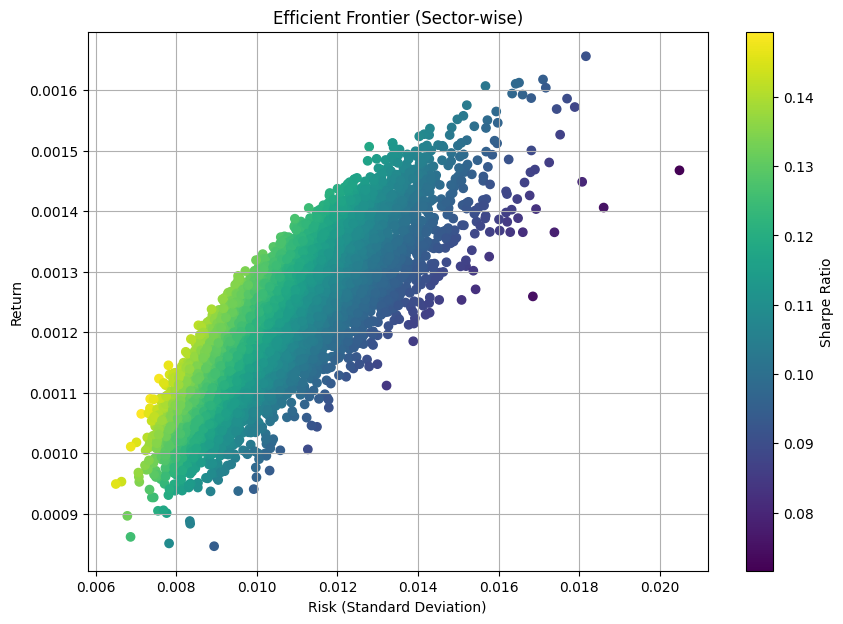

In [127]:
# Step 5: Plot Efficient Frontier for Sectors
def plot_efficient_frontier_sectors(mean_returns, cov_matrix):
    num_portfolios = 10000
    results = np.zeros((3, num_portfolios))  # Return, Std Dev, Sharpe Ratio

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)  # Normalize weights to sum to 1
        
        # Calculate portfolio return and standard deviation
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

    # Plotting the results
    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
    plt.title('Efficient Frontier (Sector-wise)')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.grid(True)
    plt.show()

# Plot the efficient frontier for sectors
plot_efficient_frontier_sectors(mean_returns, cov_matrix)


In [18]:
import os
import pandas as pd
import numpy as np

# Define the portfolio for each sector
sectors = {
    "Financial Services": ["AXISBANK", "BAJFINANCE", "HDFCBANK", "HDFCLIFE", "ICICIBANK", "INDUSINDBANK", "KOTAKBANK", "SHRIRAMFIN", "SBIN", "SBILIFE", "BAJFINSV"],
    "Information Technology": ["INFY", "TCS", "WIPRO", "TECHM", "HCLTECH", "LTIM"],
    "Automobile and Auto Components": ["TATAMOTORS", "BAJAJ-AUTO", "EICHERMOT", "M&M", "HEROMOTOCO", "MARUTI"],
    "FMCG": ["ITC", "BRITANIA", "HINDUNILVR", "NESTLEIND", "TATACONSUM"],
    "Healthcare": ["APOLLOHOSP", "CIPLA", "DIVISLAB", "DRREDDY", "SUNPHARMA"],
    "Oil Gas & Consumable Fuels": ["BPCL", "COALINDIA", "ONGC", "RELIANCE"],
    "Metals and Mining": ["ADANIENT", "HINDALCO", "JSWSTEEL", "TATASTEEL"],
    "Construction": ["ULTRATECHCEMCO", "GRASIM", "LT"],
    "Power": ["NTPC", "POWERGRID"],
    "Consumer Durables": ["TITAN", "ASIANPAINT"],
    "Services": ["ADANIPORTS"],
    "Telecommunication": ["BHARATIARTL"]
}

# Function to load stock data for each stock
def load_stock_data(stock):
    file_path = f'C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017/{stock}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"Data for {stock} not found!")
        return None

# Function to calculate sector-wise portfolio risk
def calculate_sector_risk(sector_stocks):
    sector_data = []
    
    for stock in sector_stocks:
        df = load_stock_data(stock)
        if df is not None:
            df['Returns'] = df['Close'].pct_change()  # Assuming 'Close' price is used for returns
            sector_data.append(df['Returns'].dropna())

    if sector_data:
        sector_returns = pd.concat(sector_data, axis=1)
        sector_cov_matrix = sector_returns.cov()  # Covariance matrix for the sector
        sector_weights = np.ones(len(sector_stocks)) / len(sector_stocks)  # Equal weights
        portfolio_variance = np.dot(sector_weights.T, np.dot(sector_cov_matrix, sector_weights))
        portfolio_risk = np.sqrt(portfolio_variance)
        return portfolio_risk
    else:
        return None

# Calculate and display risk for each sector
sector_risks = {}
for sector, stocks in sectors.items():
    risk = calculate_sector_risk(stocks)
    if risk is not None:
        sector_risks[sector] = risk
        print(f"Portfolio Risk for {sector}: {risk:.4f}")
    else:
        print(f"Could not calculate risk for {sector} due to missing data.")

Data for INDUSINDBANK not found!
Data for SHRIRAMFIN not found!
Data for BAJFINSV not found!


ValueError: shapes (8,8) and (11,) not aligned: 8 (dim 1) != 11 (dim 0)

In [19]:
import os
import pandas as pd
import numpy as np

# Define the portfolio for each sector using NIFTY 50 symbols
sectors = {
    "Financial Services": ["AXISBANK", "BAJFINANCE", "HDFCBANK", "HDFCLIFE", "ICICIBANK", "INDUSINDBANK", "KOTAKBANK", "SHRIRAMFIN", "SBIN", "SBILIFE", "BAJFINSV"],
    "Information Technology": ["INFY", "TCS", "WIPRO", "TECHM", "HCLTECH", "LTIM"],
    "Automobile and Auto Components": ["TATAMOTORS", "BAJAJ-AUTO", "EICHERMOT", "M&M", "HEROMOTOCO", "MARUTI"],
    "FMCG": ["ITC", "BRITANIA", "HINDUNILVR", "NESTLEIND", "TATACONSUM"],
    "Healthcare": ["APOLLOHOSP", "CIPLA", "DIVISLAB", "DRREDDY", "SUNPHARMA"],
    "Oil Gas & Consumable Fuels": ["BPCL", "COALINDIA", "ONGC", "RELIANCE"],
    "Metals and Mining": ["ADANIENT", "HINDALCO", "JSWSTEEL", "TATASTEEL"],
    "Construction": ["ULTRATECHCEMCO", "GRASIM", "LT"],
    "Power": ["NTPC", "POWERGRID"],
    "Consumer Durables": ["TITAN", "ASIANPAINT"],
    "Services": ["ADANIPORTS"],
    "Telecommunication": ["BHARATIARTL"]
}

# Function to load stock data for each stock
def load_stock_data(stock):
    file_path = f'path_to_csv_files/{stock}.csv'  # Update with actual path to CSV files
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"Data for {stock} not found!")
        return None

# Function to calculate sector-wise portfolio risk
def calculate_sector_risk(sector_stocks):
    sector_data = []
    
    for stock in sector_stocks:
        df = load_stock_data(stock)
        if df is not None:
            df['Returns'] = df['Close'].pct_change()  # Assuming 'Close' price is used for returns
            sector_data.append(df['Returns'].dropna())

    if sector_data:
        sector_returns = pd.concat(sector_data, axis=1)
        sector_cov_matrix = sector_returns.cov()  # Covariance matrix for the sector
        sector_weights = np.ones(len(sector_stocks)) / len(sector_stocks)  # Equal weights
        portfolio_variance = np.dot(sector_weights.T, np.dot(sector_cov_matrix, sector_weights))
        portfolio_risk = np.sqrt(portfolio_variance)
        return portfolio_risk
    else:
        return None

# Calculate and display risk for each sector
sector_risks = {}
for sector, stocks in sectors.items():
    risk = calculate_sector_risk(stocks)
    if risk is not None:
        sector_risks[sector] = risk
        print(f"Portfolio Risk for {sector}: {risk:.4f}")
    else:
        print(f"Could not calculate risk for {sector} due to missing data.")


Data for AXISBANK not found!
Data for BAJFINANCE not found!
Data for HDFCBANK not found!
Data for HDFCLIFE not found!
Data for ICICIBANK not found!
Data for INDUSINDBANK not found!
Data for KOTAKBANK not found!
Data for SHRIRAMFIN not found!
Data for SBIN not found!
Data for SBILIFE not found!
Data for BAJFINSV not found!
Could not calculate risk for Financial Services due to missing data.
Data for INFY not found!
Data for TCS not found!
Data for WIPRO not found!
Data for TECHM not found!
Data for HCLTECH not found!
Data for LTIM not found!
Could not calculate risk for Information Technology due to missing data.
Data for TATAMOTORS not found!
Data for BAJAJ-AUTO not found!
Data for EICHERMOT not found!
Data for M&M not found!
Data for HEROMOTOCO not found!
Data for MARUTI not found!
Could not calculate risk for Automobile and Auto Components due to missing data.
Data for ITC not found!
Data for BRITANIA not found!
Data for HINDUNILVR not found!
Data for NESTLEIND not found!
Data for TA

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cholesky
from numpy.random import normal
from scipy.optimize import minimize
import os

In [21]:
# Sector-wise NIFTY 50 portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH', 'LTIM'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [22]:
directory = 'C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017'


In [23]:
# Step 1: Load NIFTY 50 data from CSVs
stock_data = {}

# Load each CSV file and store in stock_data
for sector, stock_list in sector_portfolios.items():
    for stock in stock_list:
        file_name = f"{stock}.csv"
        file_path = os.path.join(directory, file_name)
        
        if os.path.exists(file_path):
            stock_data[stock] = pd.read_csv(file_path)
        else:
            print(f"File for {stock} not found.")

File for LTIM not found.


In [24]:
# Combine closing prices for all stocks
close_prices = pd.DataFrame()
for stock, df in stock_data.items():
    close_prices[stock] = df['Close']


In [25]:
# Step 2: Calculate daily returns
returns = close_prices.pct_change().dropna()

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1054269990.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


In [26]:
# Step 3: Portfolio Optimization - Markowitz Efficient Frontier
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights should be 1
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Minimize the variance (risk) given a set return
    def minimize_variance(weights):
        return portfolio_variance(weights, cov_matrix)

    result = minimize(minimize_variance, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [27]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [28]:
# Optimizing the portfolio
optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

# Get the optimal weights, returns, and risk (variance)
optimal_weights = optimal_portfolio['x']
optimal_return = portfolio_return(optimal_weights, mean_returns)
optimal_variance = portfolio_variance(optimal_weights, cov_matrix)

In [29]:
print(f"Optimal Portfolio Weights: {optimal_weights}")
print(f"Optimal Portfolio Return: {optimal_return}")
print(f"Optimal Portfolio Variance: {optimal_variance}")

Optimal Portfolio Weights: [2.18666931e-02 1.19262239e-18 2.27986191e-02 2.47050362e-02
 2.30421165e-02 2.35136880e-02 1.76311953e-02 2.38681675e-02
 2.29819386e-02 2.47794307e-02 2.22788950e-02 2.33262773e-02
 2.17509790e-02 2.45027653e-02 2.43501729e-02 2.14041673e-02
 2.43208448e-02 6.50521303e-19 2.30963623e-02 2.38890263e-02
 2.45806379e-02 2.32939607e-02 2.37500751e-02 2.31834503e-02
 2.48134721e-02 2.26273986e-02 2.38333304e-02 4.04936118e-04
 2.43916832e-02 2.29321046e-02 2.30096144e-02 9.79444670e-03
 2.47949019e-02 2.12490465e-02 1.95847430e-02 2.34620847e-02
 2.17879575e-02 2.36157035e-02 2.85655477e-03 2.43235238e-02
 1.03428734e-02 2.40864863e-02 2.47489080e-02 2.47253586e-02
 2.18478682e-02 2.41045432e-02 2.42395633e-02 2.35083978e-02]
Optimal Portfolio Return: 0.000878069683728878
Optimal Portfolio Variance: 2.6667159676104476e-05


In [30]:
def monte_carlo_var(portfolio_weights, returns, cov_matrix, num_simulations=1000, confidence_level=0.95):
    num_assets = len(returns.columns)
    portfolio_mean = np.dot(portfolio_weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))
    
    # Simulate portfolio returns
    simulated_returns = np.random.normal(portfolio_mean, portfolio_stddev, num_simulations)
    
    # Calculate VaR at the given confidence level
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return var_value

In [31]:
# Running Monte Carlo Simulation for VaR
confidence_level = 0.95
var_95 = monte_carlo_var(optimal_weights, returns, cov_matrix, confidence_level=confidence_level)

print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95}")


Value at Risk (VaR) at 95.0% confidence level: -0.0076524853792841055


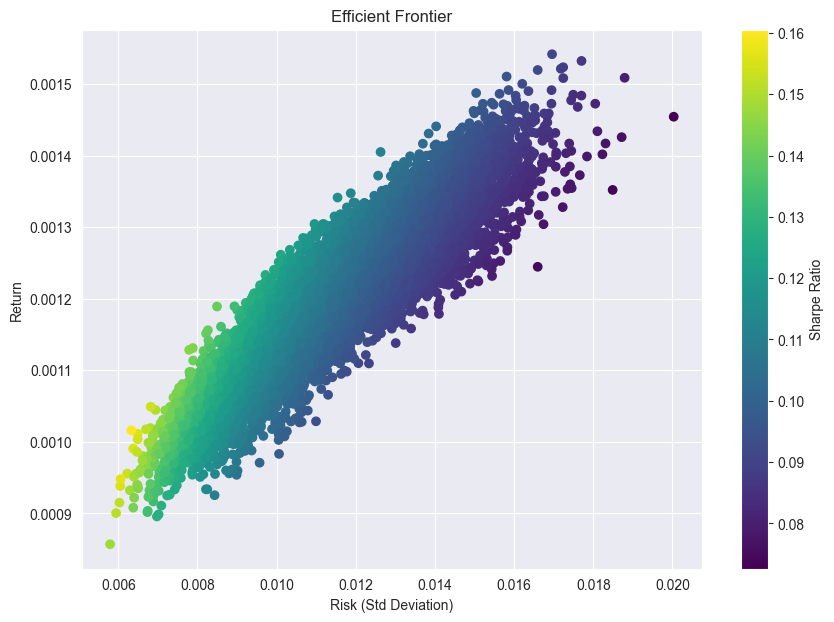

In [32]:
# Step 5: Plot Efficient Frontier
def plot_efficient_frontier(mean_returns, cov_matrix):
    num_portfolios = 10000
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

# Plot the efficient frontier
plot_efficient_frontier(mean_returns, cov_matrix)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

In [34]:
# Sector-wise NIFTY 50 portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH', 'LTIM'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [35]:
directory = 'C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017'


In [36]:
# Define functions for portfolio optimization and risk assessment
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def minimize_variance(weights):
        return portfolio_variance(weights, cov_matrix)

    result = minimize(minimize_variance, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def monte_carlo_var(portfolio_weights, returns, cov_matrix, num_simulations=1000, confidence_level=0.95):
    num_assets = len(returns.columns)
    portfolio_mean = np.dot(portfolio_weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))
    
    simulated_returns = np.random.normal(portfolio_mean, portfolio_stddev, num_simulations)
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return var_value


In [37]:
# Perform analysis for each sector as a single portfolio
for sector, stocks in sector_portfolios.items():
    # Load and combine stock data for the sector
    sector_data = {}
    for stock in stocks:
        file_name = f"{stock}.csv"
        file_path = os.path.join(directory, file_name)
        
        if os.path.exists(file_path):
            sector_data[stock] = pd.read_csv(file_path)
        else:
            print(f"File for {stock} not found in sector {sector}.")

    # Combine closing prices for the sector
    close_prices = pd.DataFrame()
    for stock, df in sector_data.items():
        close_prices[stock] = df['Close']

    # Calculate daily returns
    returns = close_prices.pct_change().dropna()
    
    # Compute mean returns and covariance matrix
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Optimize the portfolio
    optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

    # Get the optimal weights, returns, and risk (variance)
    optimal_weights = optimal_portfolio['x']
    optimal_return = portfolio_return(optimal_weights, mean_returns)
    optimal_variance = portfolio_variance(optimal_weights, cov_matrix)
    confidence_level = 0.95
    var_95 = monte_carlo_var(optimal_weights, returns, cov_matrix, confidence_level=confidence_level)

    print(f"\nSector: {sector}")
    print(f"Optimal Portfolio Weights: {optimal_weights}")
    print(f"Optimal Portfolio Return: {optimal_return}")
    print(f"Optimal Portfolio Variance: {optimal_variance}")
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95}")


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_


Sector: Financial Services
Optimal Portfolio Weights: [0.11328122 0.         0.11702515 0.11868117 0.11313169 0.1134874
 0.07527387 0.11446984 0.11495845 0.11969121]
Optimal Portfolio Return: 0.0008906596147417548
Optimal Portfolio Variance: 8.638254913236145e-05
Value at Risk (VaR) at 95.0% confidence level: -0.01506106397929223
File for LTIM not found in sector Information Technology.

Sector: Information Technology
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0008051141195073486
Optimal Portfolio Variance: 0.00016401124976872782
Value at Risk (VaR) at 95.0% confidence level: -0.02055693896434828

Sector: Automobile and Auto Components
Optimal Portfolio Weights: [0.19280455 0.20141786 0.00855313 0.19469279 0.2016422  0.20088947]
Optimal Portfolio Return: 0.0008867110022980191
Optimal Portfolio Variance: 0.00010598861609140816
Value at Risk (VaR) at 95.0% confidence level: -0.015966967691688698


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_


Sector: Fast Moving Consumer Goods
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0006474151650221231
Optimal Portfolio Variance: 8.384585956381233e-05
Value at Risk (VaR) at 95.0% confidence level: -0.01395283850133183

Sector: Healthcare
Optimal Portfolio Weights: [0.24998655 0.00150242 0.24999255 0.24892003 0.24959844]
Optimal Portfolio Return: 0.0010783002675130667
Optimal Portfolio Variance: 0.0001411227421065707
Value at Risk (VaR) at 95.0% confidence level: -0.01762919734258752

Sector: Oil Gas & Consumable Fuels
Optimal Portfolio Weights: [0.         0.40519786 0.31816768 0.27663446]
Optimal Portfolio Return: 0.0005872763037934078
Optimal Portfolio Variance: 0.00020340357266136253
Value at Risk (VaR) at 95.0% confidence level: -0.02199687782920842

Sector: Metals and Mining
Optimal Portfolio Weights: [0.32860148 0.33068522 0.33507054 0.00564276]
Optimal Portfolio Return: 0.0013311983883133077
Optimal Portfolio Variance: 0.00030828572543761975
Valu

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()
C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1556834999.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Financial Services
Optimal Portfolio Weights: [0.11328122 0.         0.11702515 0.11868117 0.11313169 0.1134874
 0.07527387 0.11446984 0.11495845 0.11969121]
Optimal Portfolio Return: 0.0008906596147417548
Optimal Portfolio Variance: 8.638254913236145e-05
Value at Risk (VaR) at 95.0% confidence level: -0.014559548624245003


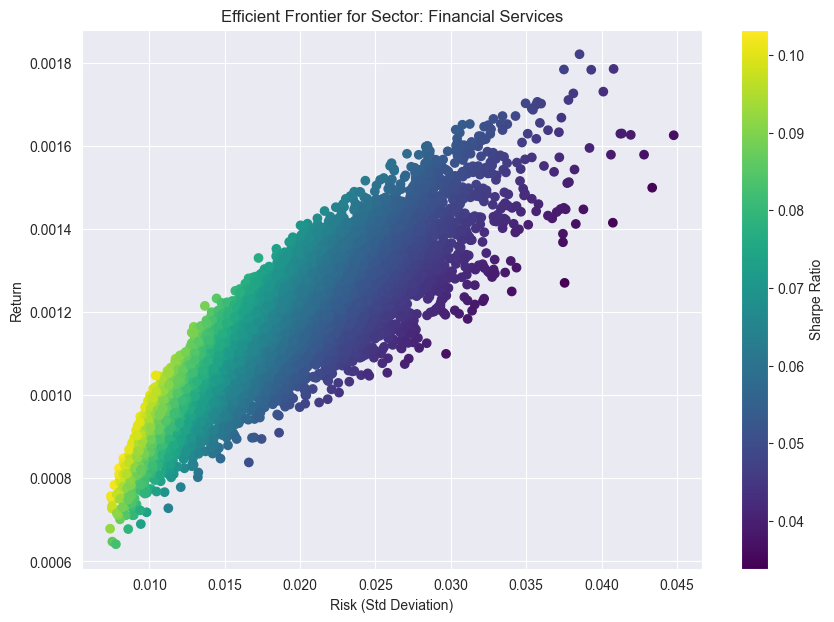

File for LTIM not found in sector Information Technology.

Sector: Information Technology
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0008051141195073486
Optimal Portfolio Variance: 0.00016401124976872782
Value at Risk (VaR) at 95.0% confidence level: -0.021558918186660725


C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


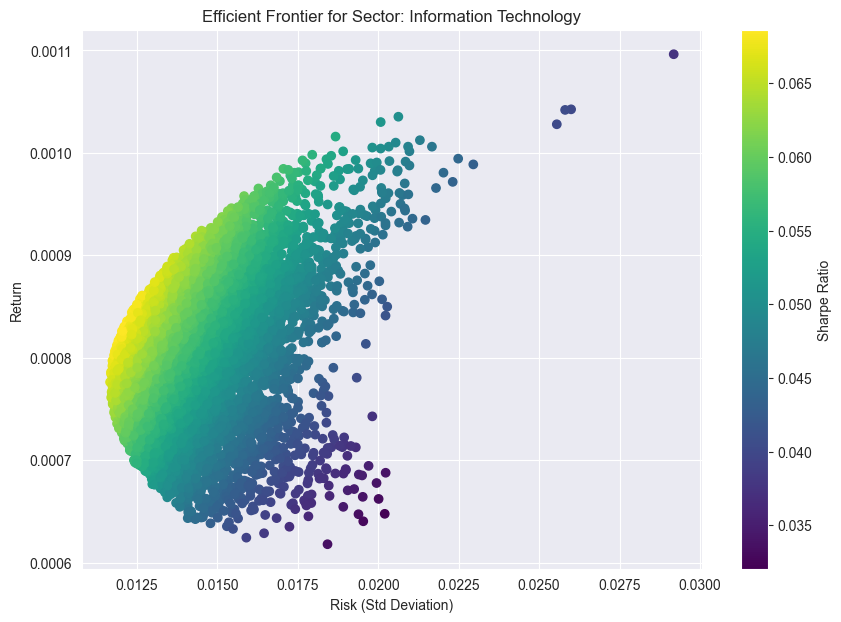

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Automobile and Auto Components
Optimal Portfolio Weights: [0.19280455 0.20141786 0.00855313 0.19469279 0.2016422  0.20088947]
Optimal Portfolio Return: 0.0008867110022980191
Optimal Portfolio Variance: 0.00010598861609140816
Value at Risk (VaR) at 95.0% confidence level: -0.0163160236901823


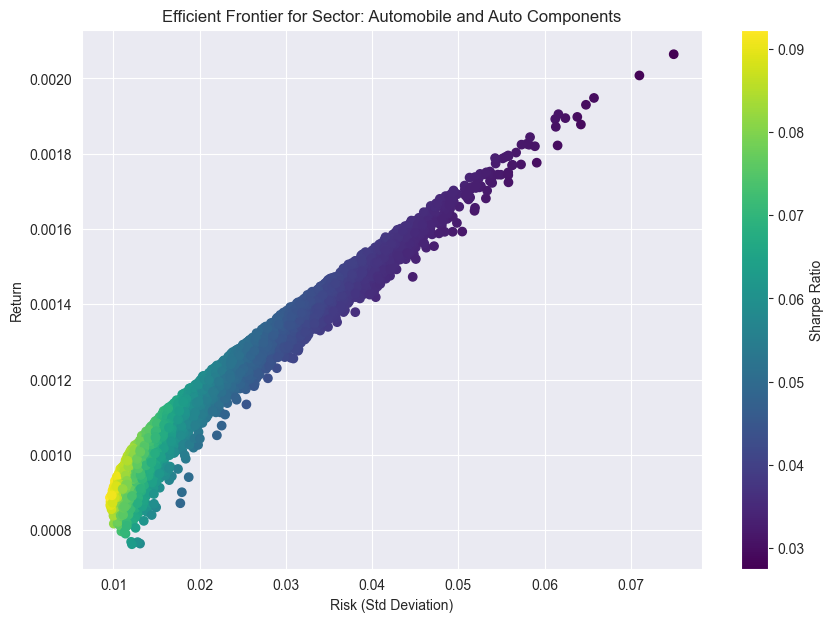

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Fast Moving Consumer Goods
Optimal Portfolio Weights: [0.2 0.2 0.2 0.2 0.2]
Optimal Portfolio Return: 0.0006474151650221231
Optimal Portfolio Variance: 8.384585956381233e-05
Value at Risk (VaR) at 95.0% confidence level: -0.014696468637212787


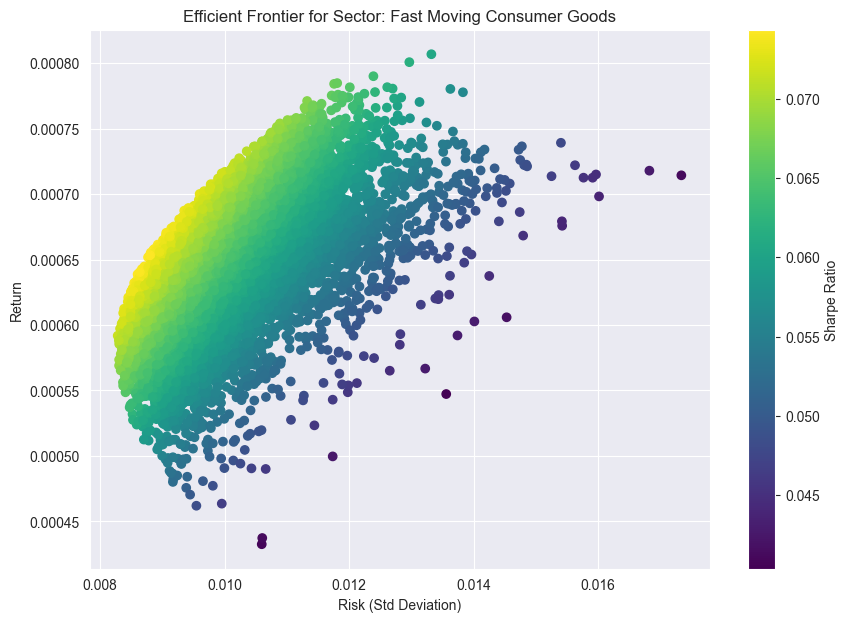

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Healthcare
Optimal Portfolio Weights: [0.24998655 0.00150242 0.24999255 0.24892003 0.24959844]
Optimal Portfolio Return: 0.0010783002675130667
Optimal Portfolio Variance: 0.0001411227421065707
Value at Risk (VaR) at 95.0% confidence level: -0.01833801732214915


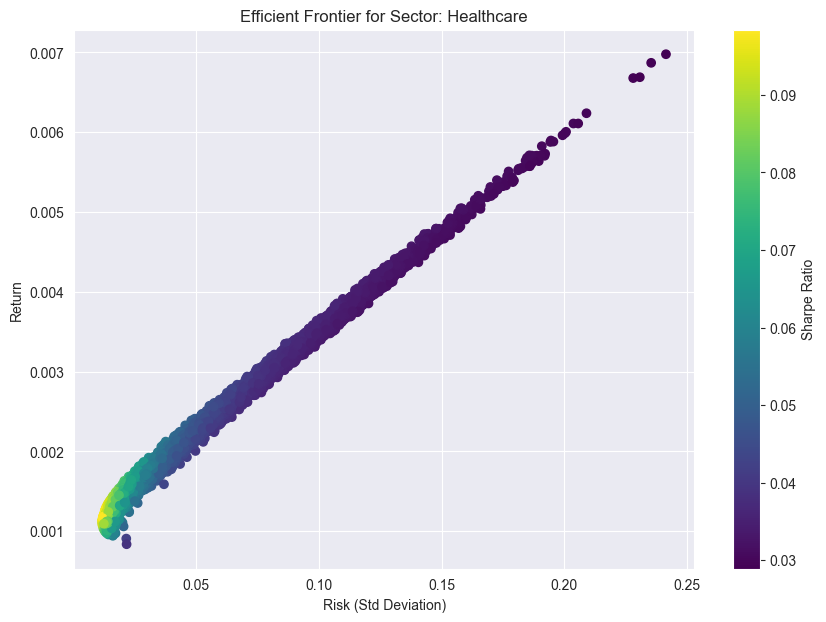

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Oil Gas & Consumable Fuels
Optimal Portfolio Weights: [0.         0.40519786 0.31816768 0.27663446]
Optimal Portfolio Return: 0.0005872763037934078
Optimal Portfolio Variance: 0.00020340357266136253
Value at Risk (VaR) at 95.0% confidence level: -0.020990717019182575


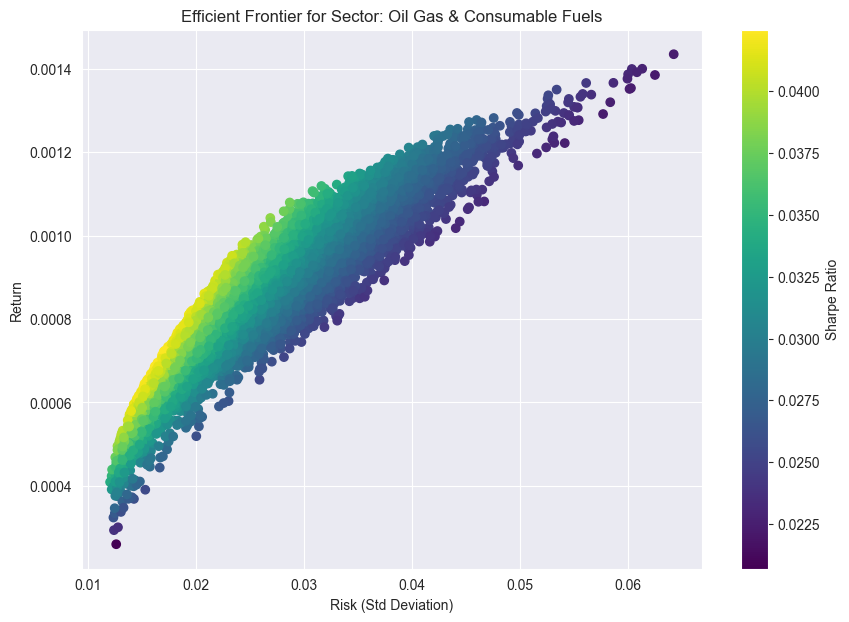

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Metals and Mining
Optimal Portfolio Weights: [0.32860148 0.33068522 0.33507054 0.00564276]
Optimal Portfolio Return: 0.0013311983883133077
Optimal Portfolio Variance: 0.00030828572543761975
Value at Risk (VaR) at 95.0% confidence level: -0.026359282455423926


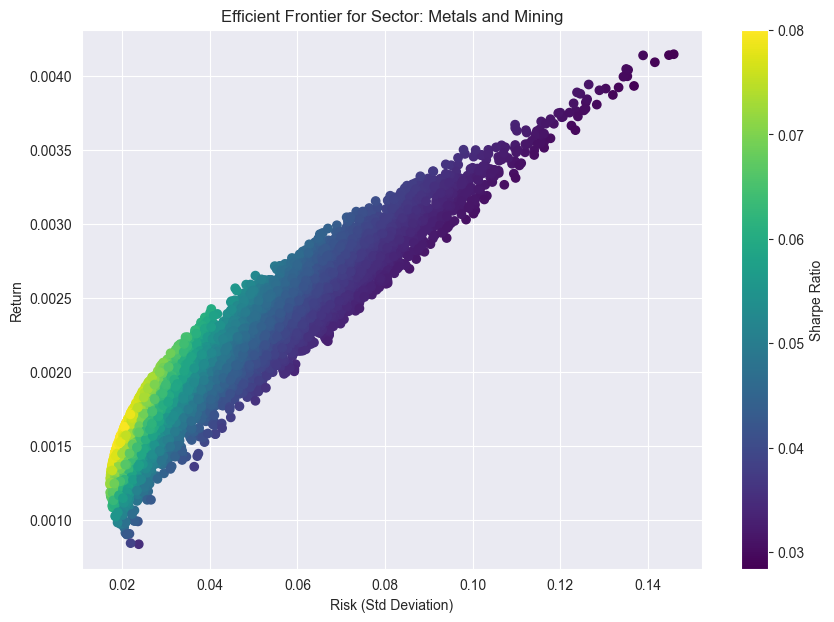


Sector: Construction
Optimal Portfolio Weights: [0.48452445 0.04760192 0.46787363]
Optimal Portfolio Return: 0.0011058388958042772
Optimal Portfolio Variance: 0.0002858029112634259
Value at Risk (VaR) at 95.0% confidence level: -0.02585131283954951


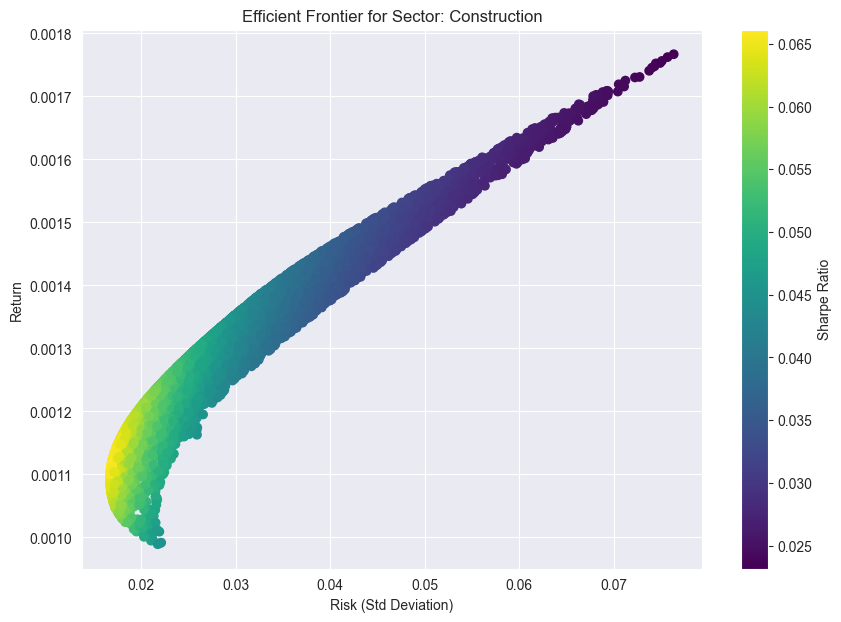

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Power
Optimal Portfolio Weights: [0.5 0.5]
Optimal Portfolio Return: 0.0005348449189742846
Optimal Portfolio Variance: 0.00015557908942749187
Value at Risk (VaR) at 95.0% confidence level: -0.01826514132021794


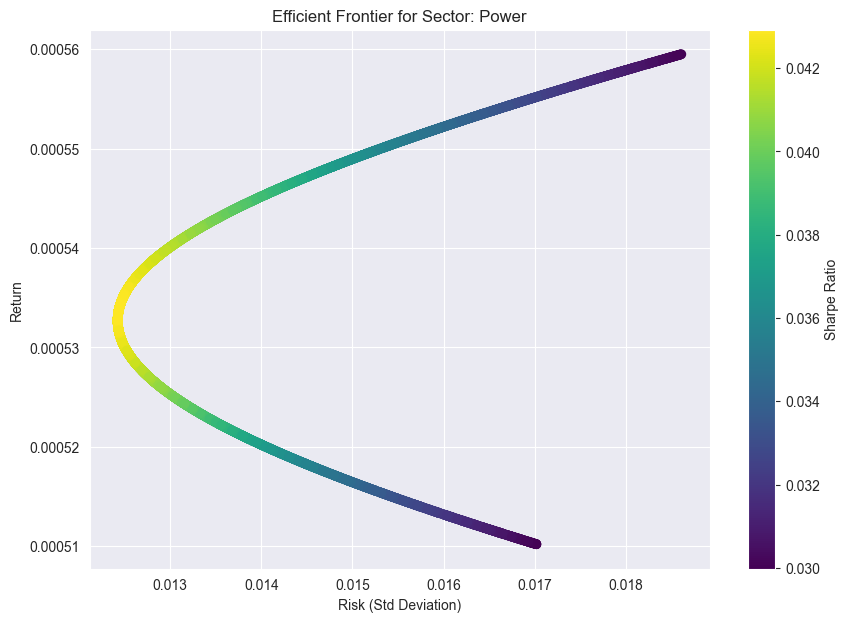

C:\Users\kamis\AppData\Local\Temp\ipykernel_12132\1396585435.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()



Sector: Consumer Durables
Optimal Portfolio Weights: [0.5 0.5]
Optimal Portfolio Return: 0.0011448759350786658
Optimal Portfolio Variance: 0.00025105720950725145
Value at Risk (VaR) at 95.0% confidence level: -0.02442476991804146


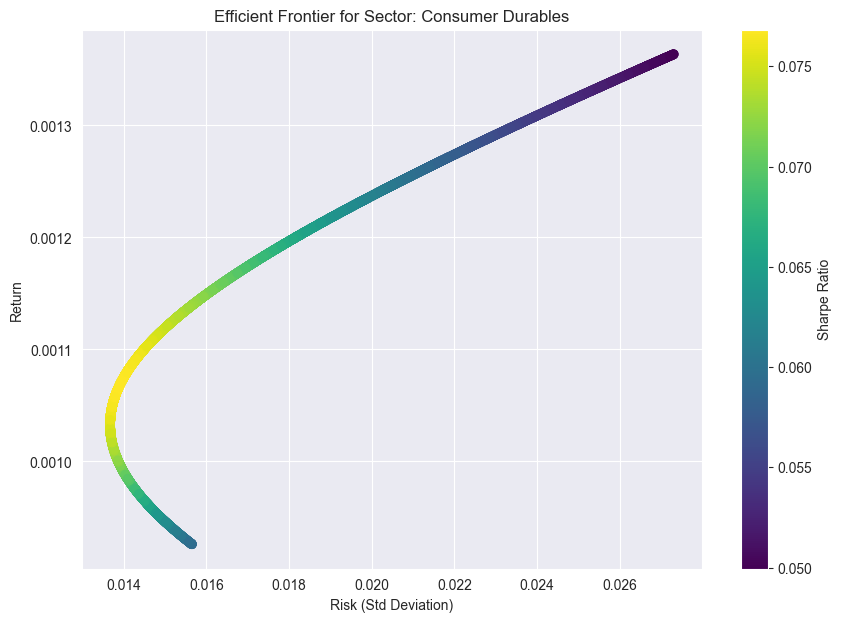


Sector: Services
Optimal Portfolio Weights: [1.]
Optimal Portfolio Return: 0.0008523566598222411
Optimal Portfolio Variance: 0.0007131430512318371
Value at Risk (VaR) at 95.0% confidence level: -0.04403922130068767


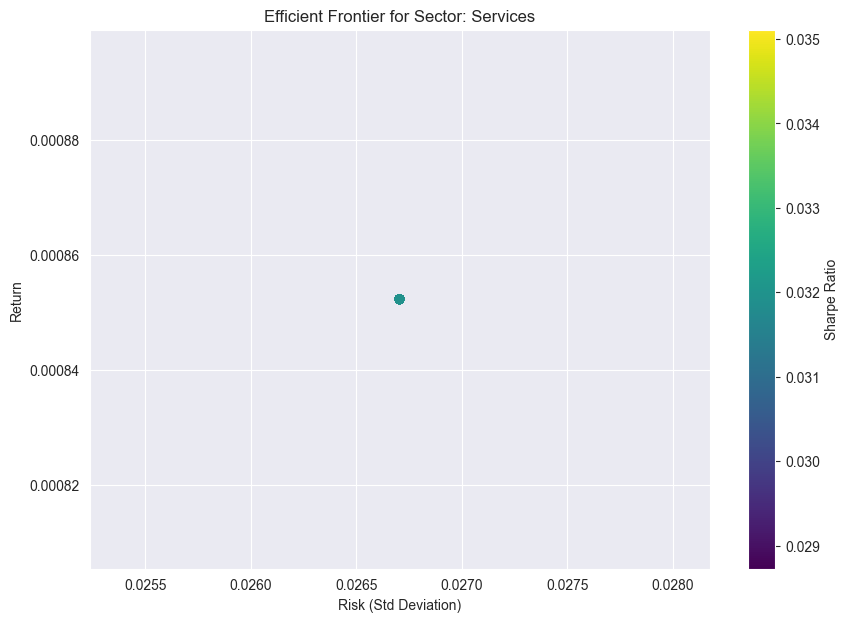


Sector: Telecommunication
Optimal Portfolio Weights: [1.]
Optimal Portfolio Return: 0.0011016250994222575
Optimal Portfolio Variance: 0.0005287492869783724
Value at Risk (VaR) at 95.0% confidence level: -0.035557792538987464


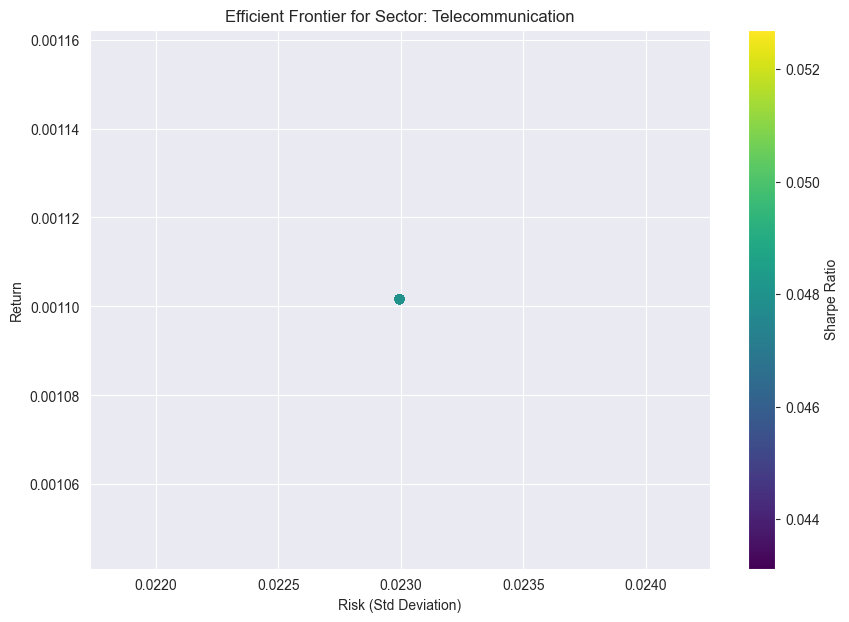

In [39]:
# Perform analysis for each sector as a single portfolio
for sector, stocks in sector_portfolios.items():
    # Load and combine stock data for the sector
    sector_data = {}
    for stock in stocks:
        file_name = f"{stock}.csv"
        file_path = os.path.join(directory, file_name)
        
        if os.path.exists(file_path):
            sector_data[stock] = pd.read_csv(file_path)
        else:
            print(f"File for {stock} not found in sector {sector}.")

    # Combine closing prices for the sector
    close_prices = pd.DataFrame()
    for stock, df in sector_data.items():
        close_prices[stock] = df['Close']

    # Calculate daily returns
    returns = close_prices.pct_change().dropna()
    
    # Compute mean returns and covariance matrix
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Optimize the portfolio
    optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix)

    # Get the optimal weights, returns, and risk (variance)
    optimal_weights = optimal_portfolio['x']
    optimal_return = portfolio_return(optimal_weights, mean_returns)
    optimal_variance = portfolio_variance(optimal_weights, cov_matrix)
    confidence_level = 0.95
    var_95 = monte_carlo_var(optimal_weights, returns, cov_matrix, confidence_level=confidence_level)

    print(f"\nSector: {sector}")
    print(f"Optimal Portfolio Weights: {optimal_weights}")
    print(f"Optimal Portfolio Return: {optimal_return}")
    print(f"Optimal Portfolio Variance: {optimal_variance}")
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var_95}")

    # Plot efficient frontier for the sector (optional)
    def plot_efficient_frontier(mean_returns, cov_matrix, sector_name):
        num_portfolios = 10000
        results = np.zeros((3, num_portfolios))
        for i in range(num_portfolios):
            weights = np.random.random(len(mean_returns))
            weights /= np.sum(weights)
            
            portfolio_return = np.dot(weights, mean_returns)
            portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            
            results[0,i] = portfolio_return
            results[1,i] = portfolio_stddev
            results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

        plt.figure(figsize=(10, 7))
        plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
        plt.title(f'Efficient Frontier for Sector: {sector_name}')
        plt.xlabel('Risk (Std Deviation)')
        plt.ylabel('Return')
        plt.colorbar(label='Sharpe Ratio')
        plt.show()

    plot_efficient_frontier(mean_returns, cov_matrix, sector)

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [24]:
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [25]:
# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

In [26]:
# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

In [27]:
# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

In [28]:
# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value

In [29]:
# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

In [30]:
# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns


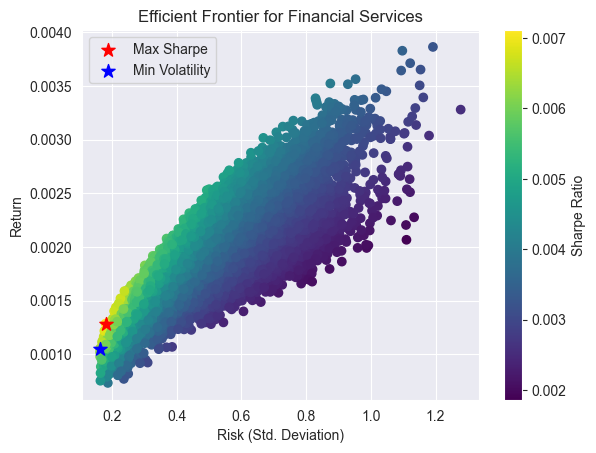

Sector: Financial Services
Value at Risk (VaR) at 95% confidence level: 0.24745308655822826


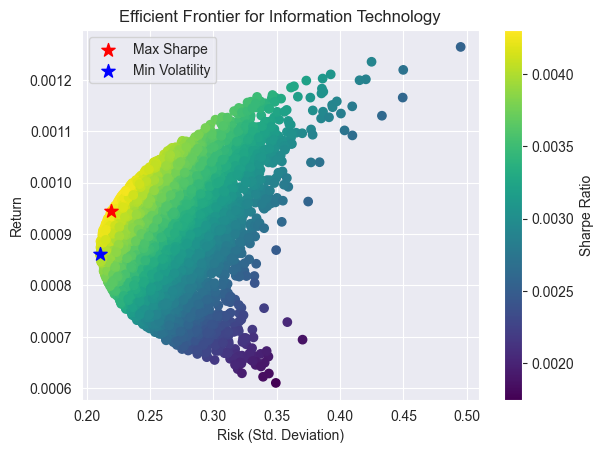

Sector: Information Technology
Value at Risk (VaR) at 95% confidence level: 0.21884118104457292


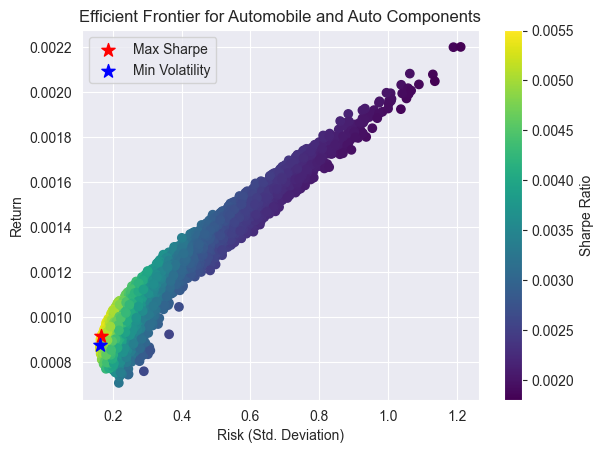

Sector: Automobile and Auto Components
Value at Risk (VaR) at 95% confidence level: 0.18925890105333099


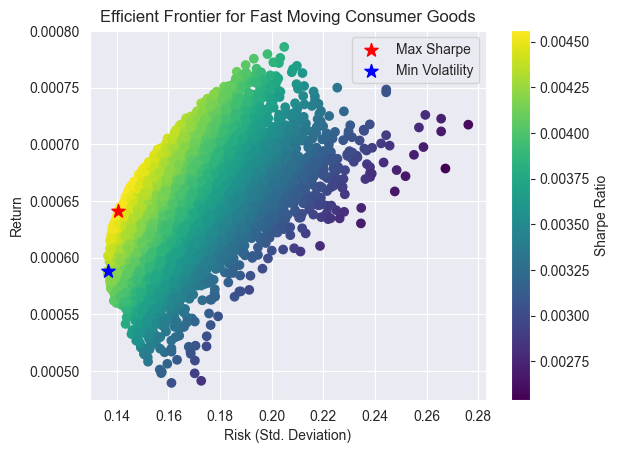

Sector: Fast Moving Consumer Goods
Value at Risk (VaR) at 95% confidence level: 0.14326893579781252


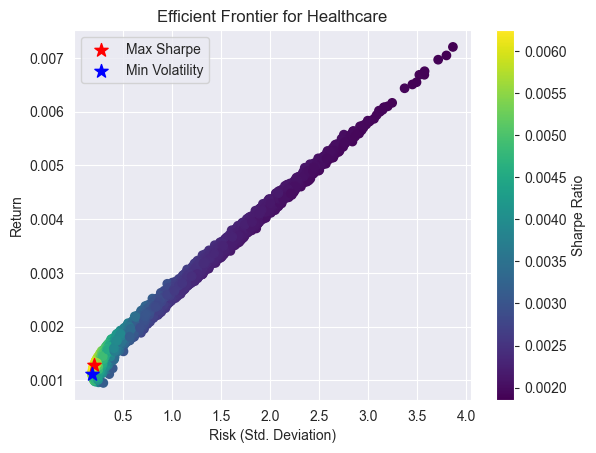

Sector: Healthcare
Value at Risk (VaR) at 95% confidence level: 0.25277560141872574


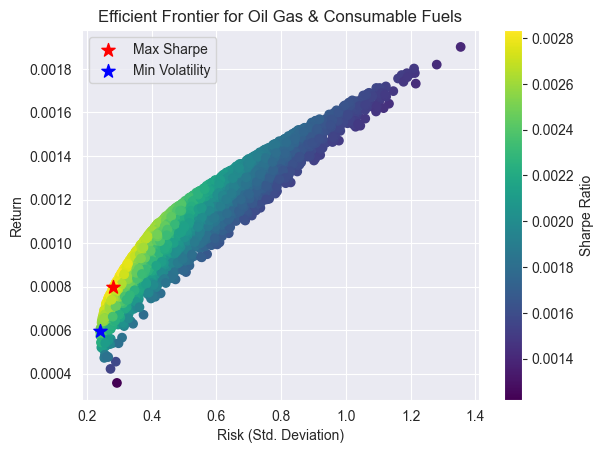

Sector: Oil Gas & Consumable Fuels
Value at Risk (VaR) at 95% confidence level: 0.3065098259131067


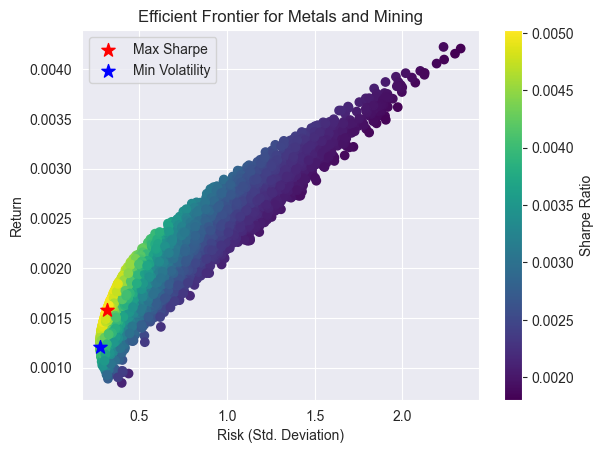

Sector: Metals and Mining
Value at Risk (VaR) at 95% confidence level: 0.31727226135738384


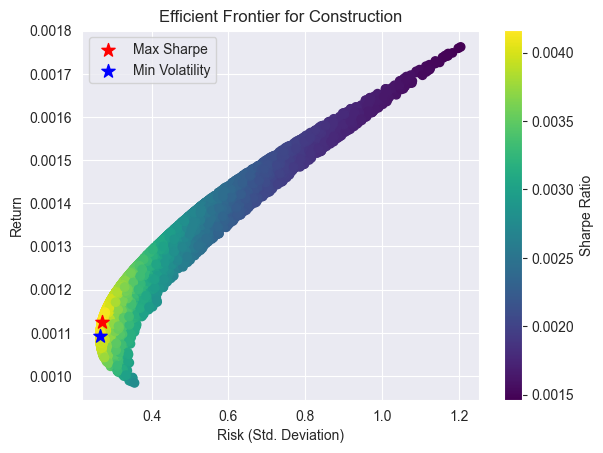

Sector: Construction
Value at Risk (VaR) at 95% confidence level: 0.27577040626188826


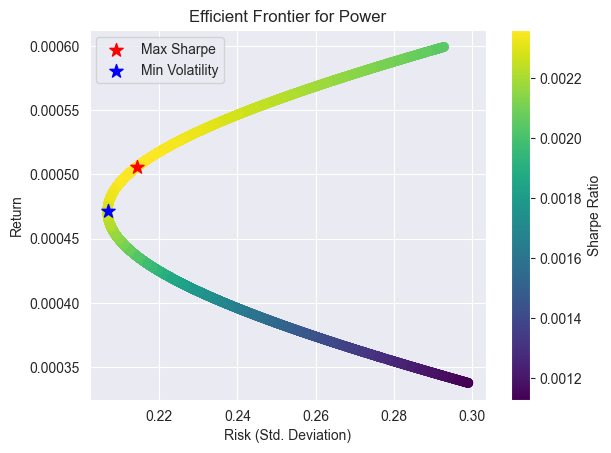

Sector: Power
Value at Risk (VaR) at 95% confidence level: 0.20690742413980628


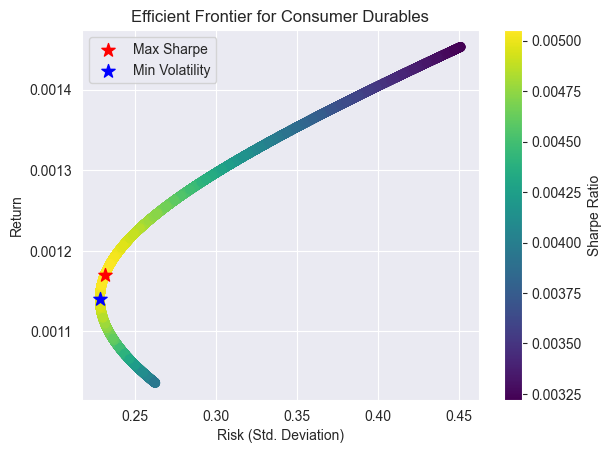

Sector: Consumer Durables
Value at Risk (VaR) at 95% confidence level: 0.2289980987957075


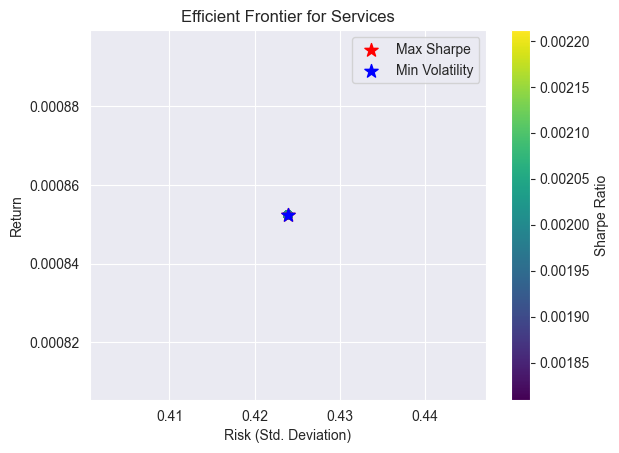

Sector: Services
Value at Risk (VaR) at 95% confidence level: 0.42392457927138755


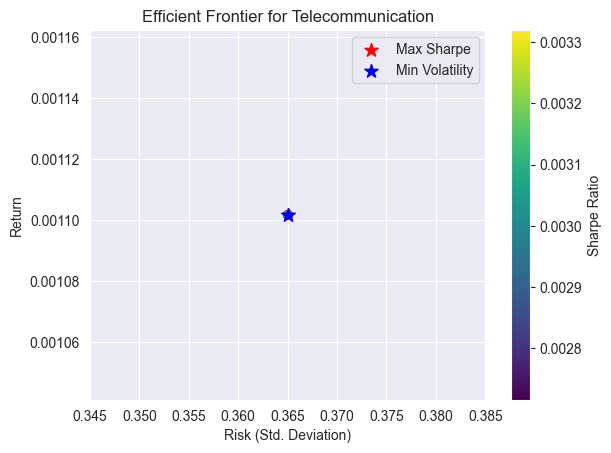

Sector: Telecommunication
Value at Risk (VaR) at 95% confidence level: 0.365027150111536


In [31]:
# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    print(f"Sector: {sector_name}")
    print(f"Value at Risk (VaR) at 95% confidence level: {var_value}")
    print("="*50)

# Loop to calculate for each sector
for sector, stocks in sector_portfolios.items():
    calculate_efficient_frontier_and_var(sector, stocks, data_directory)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    print(f"Sector: {sector_name}")
    print(f"Value at Risk (VaR) at 95% confidence level: {var_value}")
    print("="*50)
    
    # Return VaR and risk for table
    min_volatility_risk = results[1, min_volatility_idx]
    return var_value, min_volatility_risk

# Initialize lists to store results
var_results = []
risk_results = []

# Loop to calculate for each sector
for sector, stocks in sector_portfolios.items():
    var_value, risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None and risk is not None:
        var_results.append(var_value)
        risk_results.append(risk)

# Create a DataFrame to display results
results_df = pd.DataFrame({
    'Sector': list(sector_portfolios.keys()),
    'Value at Risk (VaR)': var_results,
    'Risk (Std. Deviation)': risk_results
})

print("\nSector-wise VaR and Risk:")
print(results_df)


TypeError: monte_carlo_var() missing 1 required positional argument: 'weights'

In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [34]:
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

In [35]:
# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

In [42]:
# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, weights, num_simulations=10000, confidence_level=0.95):
    num_stocks = stock_returns.shape[1]
    portfolio_risks = []
    
    for _ in range(num_simulations):
        portfolio_return = np.sum(stock_returns.mean() * weights)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(stock_returns.cov() * 252, weights)))
        portfolio_risks.append(portfolio_risk)
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))  # Return, Risk, Sharpe Ratio
    weights_record = []
    
    # Generate random portfolios
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_risk
        results[2, i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate VaR and Risk for each sector separately
def calculate_var_and_risk_for_sector(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Efficient Frontier Calculation
    num_portfolios = 10  # Number of portfolios for which we calculate VaR and risk
    results, weights_record = optimize_portfolio(mean_returns, cov_matrix, num_portfolios=num_portfolios)
    
    sector_var = []
    sector_risk = []
    
    print(f"\nVaR and Risk for {sector_name} Sector")
    print(f"{'Portfolio':<12}{'VaR(TL)':<12}{'Risk(σ)':<12}")
    
    # Loop through the portfolios and calculate VaR and Risk for each portfolio
    for i in range(num_portfolios):
        weights = weights_record[i]
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        var_value = monte_carlo_var(stock_returns, weights)
        
        sector_var.append(var_value)
        sector_risk.append(portfolio_risk)
        
        print(f"Portfolio-{i+1:<4} {var_value:<12.4f} {portfolio_risk:<12.4f}")
    
    return sector_var, sector_risk

# Loop to calculate VaR and Risk for each sector separately
sector_results = {}

In [44]:
for sector, stocks in sector_portfolios.items():
    var, risk = calculate_var_and_risk_for_sector(sector, stocks, data_directory)
    sector_results[sector] = {
        'VaR': var,
        'Risk': risk
    }

# Optional: Print final sector-wise results
print("\nSummary of VaR and Risk for each Sector:")
for sector, data in sector_results.items():
    print(f"\n{sector} Sector:")
    for i in range(len(data['VaR'])):
        print(f"Portfolio-{i+1}: VaR = {data['VaR'][i]:.4f}, Risk = {data['Risk'][i]:.4f}")


VaR and Risk for Financial Services Sector
Portfolio   VaR(TL)     Risk(σ)     
Portfolio-1    0.4889       0.4889      
Portfolio-2    0.3633       0.3633      
Portfolio-3    0.4210       0.4210      
Portfolio-4    0.3061       0.3061      
Portfolio-5    0.5024       0.5024      
Portfolio-6    0.3576       0.3576      
Portfolio-7    0.6881       0.6881      
Portfolio-8    0.5270       0.5270      
Portfolio-9    0.6682       0.6682      
Portfolio-10   1.0245       1.0245      

VaR and Risk for Information Technology Sector
Portfolio   VaR(TL)     Risk(σ)     
Portfolio-1    0.2366       0.2366      
Portfolio-2    0.2449       0.2449      
Portfolio-3    0.2534       0.2534      
Portfolio-4    0.2517       0.2517      
Portfolio-5    0.2427       0.2427      
Portfolio-6    0.2336       0.2336      
Portfolio-7    0.2707       0.2707      
Portfolio-8    0.2287       0.2287      
Portfolio-9    0.2838       0.2838      
Portfolio-10   0.2822       0.2822      

VaR and Risk 

In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load sector-wise portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, weights, num_simulations=10000, confidence_level=0.95):
    num_stocks = stock_returns.shape[1]
    portfolio_risks = []
    
    for _ in range(num_simulations):
        portfolio_return = np.sum(stock_returns.mean() * weights)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(stock_returns.cov() * 252, weights)))
        portfolio_risks.append(portfolio_risk)
    
    # Calculate VaR at the specified confidence level
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate VaR and Risk for a sector as one portfolio
def calculate_var_and_risk_for_sector(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Assume equal weights for simplicity, or you can use optimized weights
    num_assets = len(stock_list)
    weights = np.ones(num_assets) / num_assets  # Equal weights for each stock

    # Calculate portfolio performance
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)

    # Perform Monte Carlo simulation to calculate VaR
    var_value = monte_carlo_var(stock_returns, weights)

    print(f"\nVaR and Risk for {sector_name} Sector")
    print(f"{'Sector':<20}{'VaR(TL)':<12}{'Risk(σ)':<12}")
    print(f"{sector_name:<20} {var_value:<12.4f} {portfolio_risk:<12.4f}")

    return var_value, portfolio_risk

# Loop to calculate VaR and Risk for each sector separately
sector_results = {}

for sector, stocks in sector_portfolios.items():
    var, risk = calculate_var_and_risk_for_sector(sector, stocks, data_directory)
    sector_results[sector] = {
        'VaR': var,
        'Risk': risk
    }

# Optional: Print final sector-wise results
print("\nSummary of VaR and Risk for each Sector:")
for sector, data in sector_results.items():
    print(f"{sector} Sector: VaR = {data['VaR']:.4f}, Risk = {data['Risk']:.4f}")



VaR and Risk for Financial Services Sector
Sector              VaR(TL)     Risk(σ)     
Financial Services   0.4809       0.4809      

VaR and Risk for Information Technology Sector
Sector              VaR(TL)     Risk(σ)     
Information Technology 0.2298       0.2298      

VaR and Risk for Automobile and Auto Components Sector
Sector              VaR(TL)     Risk(σ)     
Automobile and Auto Components 0.3664       0.3664      

VaR and Risk for Fast Moving Consumer Goods Sector
Sector              VaR(TL)     Risk(σ)     
Fast Moving Consumer Goods 0.1500       0.1500      

VaR and Risk for Healthcare Sector
Sector              VaR(TL)     Risk(σ)     
Healthcare           1.0607       1.0607      

VaR and Risk for Oil Gas & Consumable Fuels Sector
Sector              VaR(TL)     Risk(σ)     
Oil Gas & Consumable Fuels 0.5243       0.5243      

VaR and Risk for Metals and Mining Sector
Sector              VaR(TL)     Risk(σ)     
Metals and Mining    0.7134       0.7134      



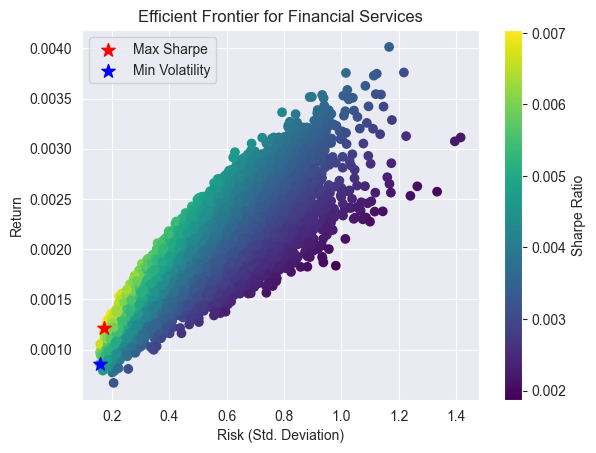

Sector: Financial Services
Value at Risk (VaR) at 95% confidence level: 0.24576603658898616
Mean Portfolio Risk: 0.5243145497280242


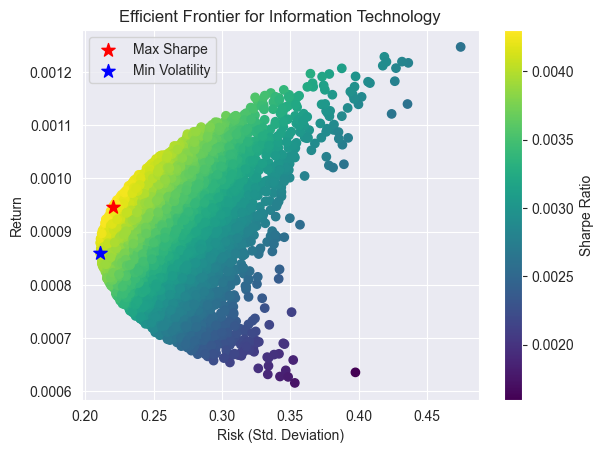

Sector: Information Technology
Value at Risk (VaR) at 95% confidence level: 0.21838995978401793
Mean Portfolio Risk: 0.25417303784295175


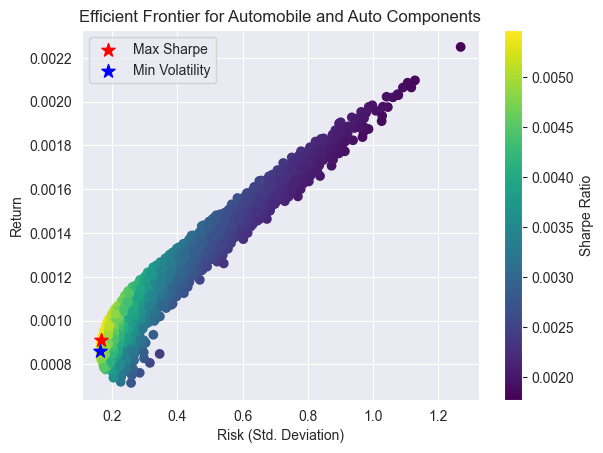

Sector: Automobile and Auto Components
Value at Risk (VaR) at 95% confidence level: 0.18891983461458367
Mean Portfolio Risk: 0.3906701516809447


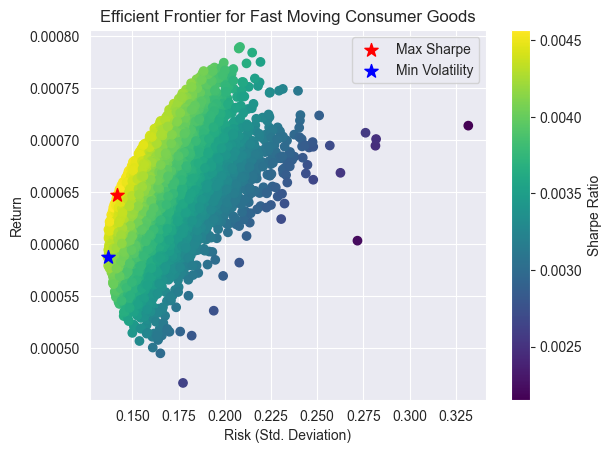

Sector: Fast Moving Consumer Goods
Value at Risk (VaR) at 95% confidence level: 0.14343786810560927
Mean Portfolio Risk: 0.16501711537293098


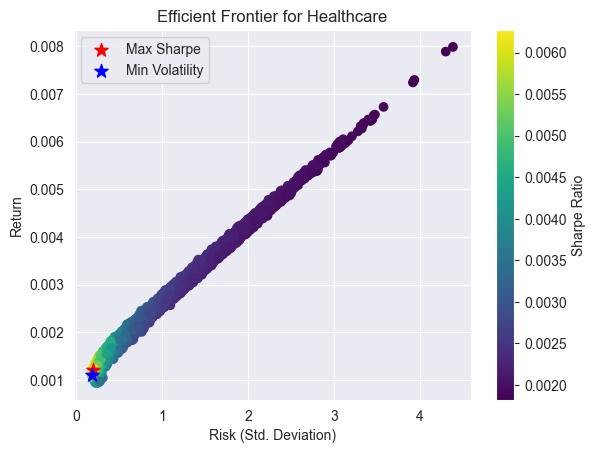

Sector: Healthcare
Value at Risk (VaR) at 95% confidence level: 0.2454379757047077
Mean Portfolio Risk: 1.0785601832551905


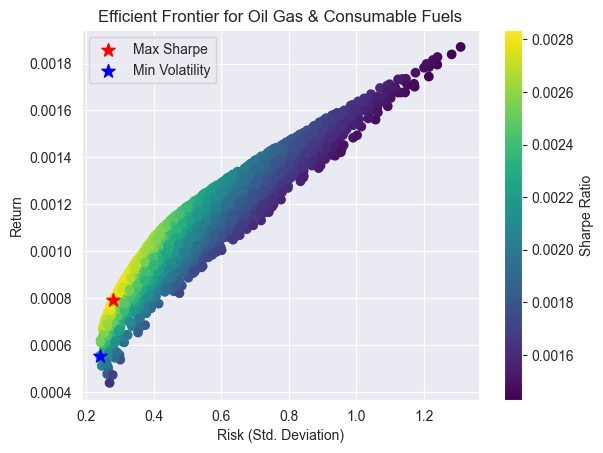

Sector: Oil Gas & Consumable Fuels
Value at Risk (VaR) at 95% confidence level: 0.30690941008370753
Mean Portfolio Risk: 0.537756497111318


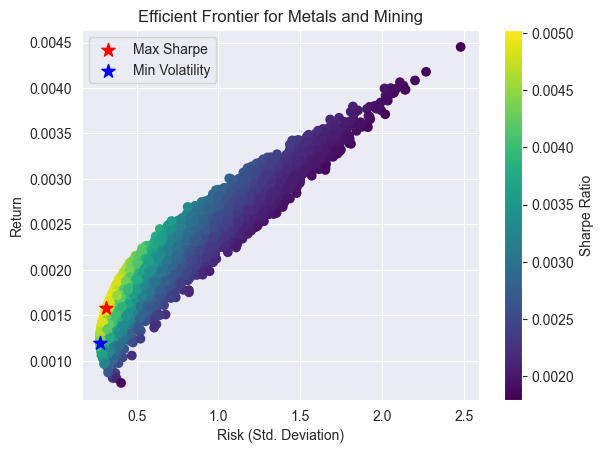

Sector: Metals and Mining
Value at Risk (VaR) at 95% confidence level: 0.31900224162688023
Mean Portfolio Risk: 0.7513611986223311


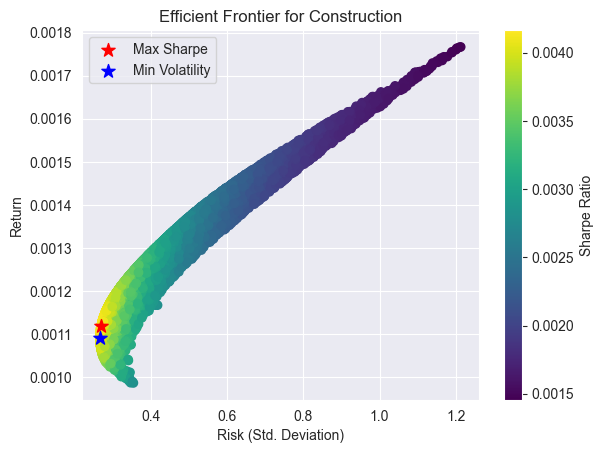

Sector: Construction
Value at Risk (VaR) at 95% confidence level: 0.2759965075579048
Mean Portfolio Risk: 0.48284527305628105


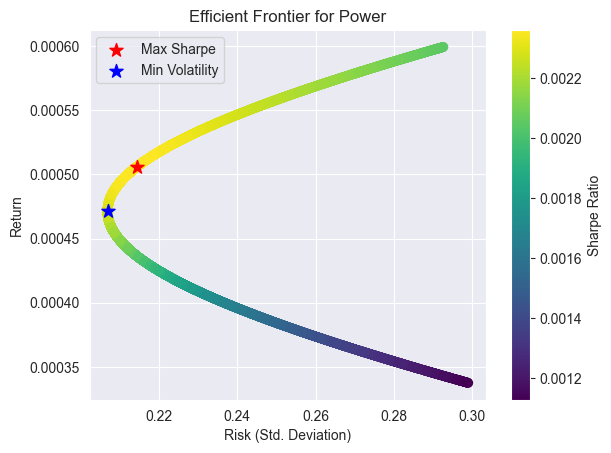

Sector: Power
Value at Risk (VaR) at 95% confidence level: 0.2068974164856128
Mean Portfolio Risk: 0.22894776018965385


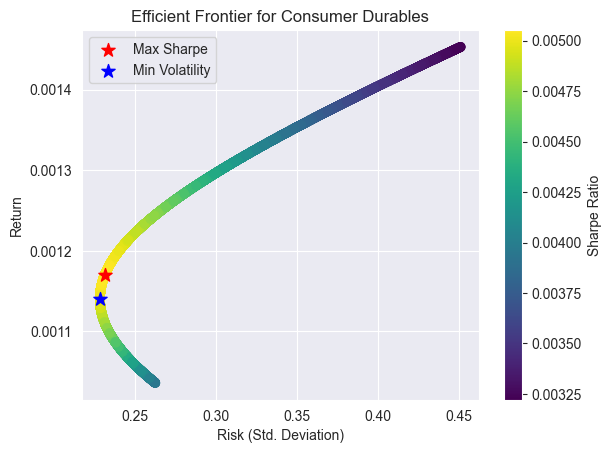

Sector: Consumer Durables
Value at Risk (VaR) at 95% confidence level: 0.22905483057316667
Mean Portfolio Risk: 0.2853775127051886


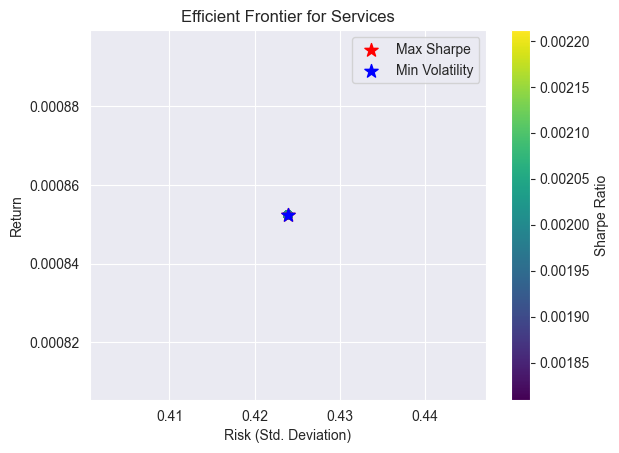

Sector: Services
Value at Risk (VaR) at 95% confidence level: 0.42392457927138755
Mean Portfolio Risk: 0.42392457927138766


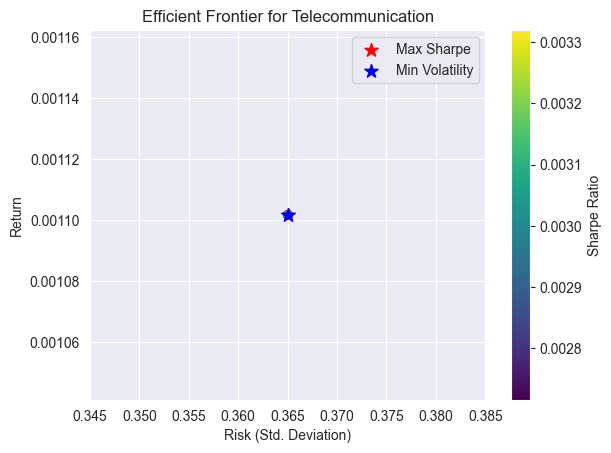

Sector: Telecommunication
Value at Risk (VaR) at 95% confidence level: 0.365027150111536
Mean Portfolio Risk: 0.365027150111536


In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    print(f"Sector: {sector_name}")
    print(f"Value at Risk (VaR) at 95% confidence level: {var_value}")
    print(f"Mean Portfolio Risk: {mean_risk}")
    print("="*50)

# Loop to calculate for each sector
for sector, stocks in sector_portfolios.items():
    calculate_efficient_frontier_and_var(sector, stocks, data_directory)


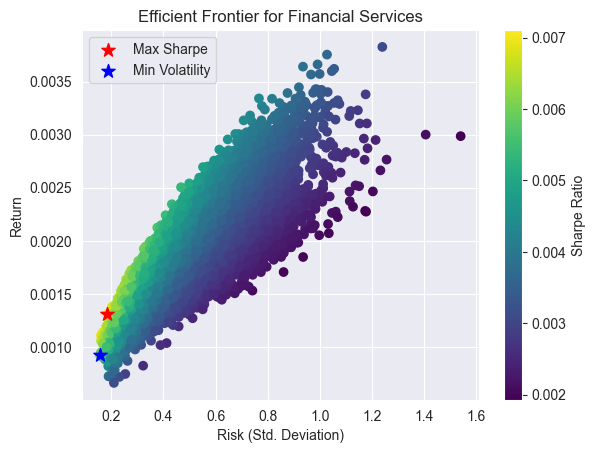

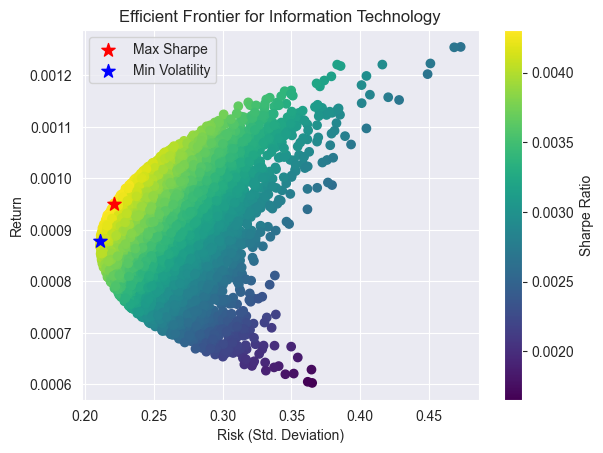

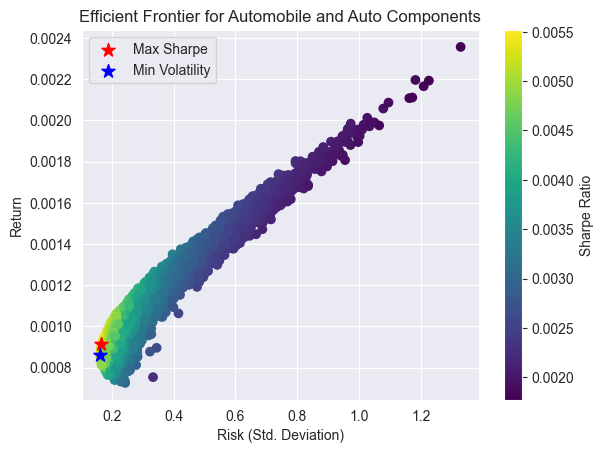

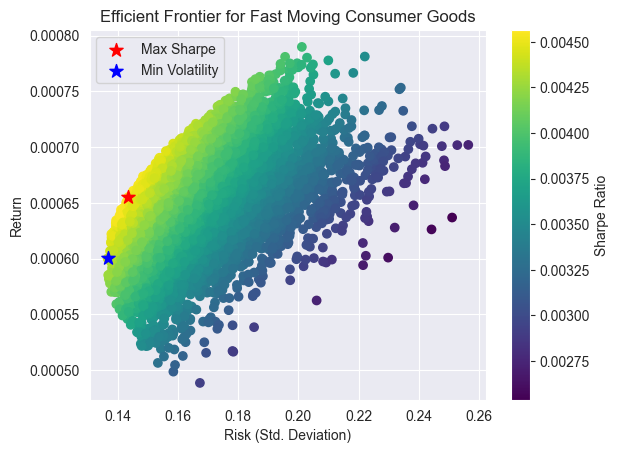

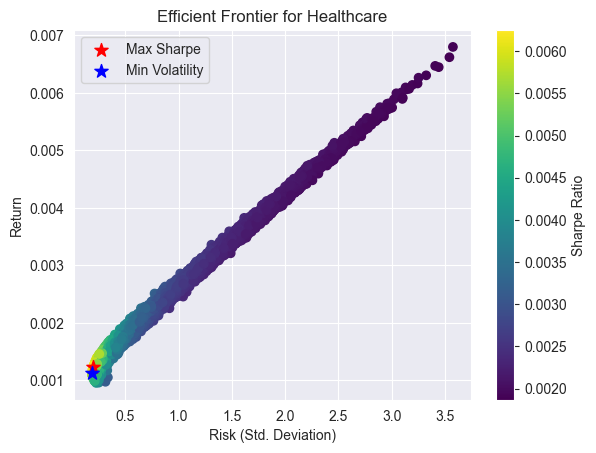

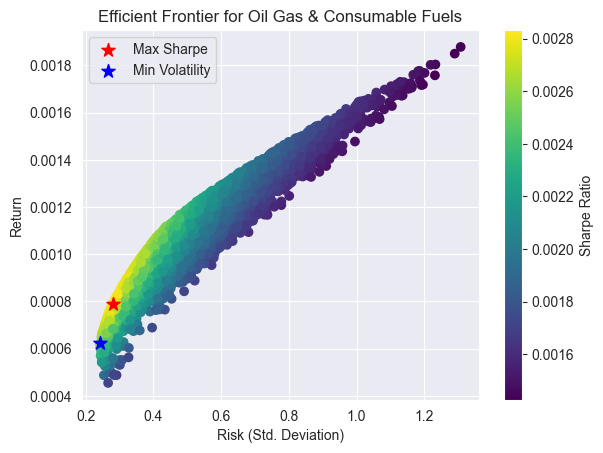

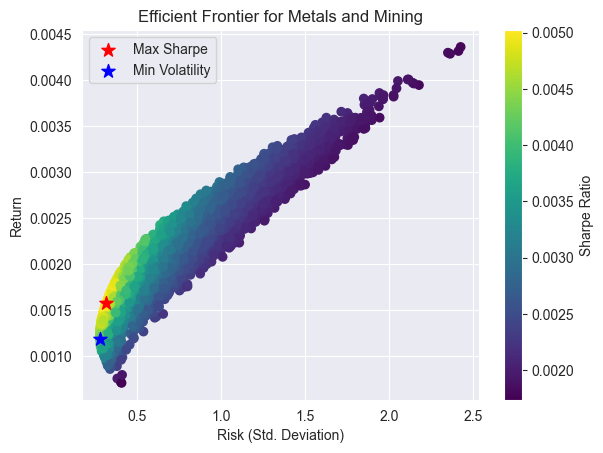

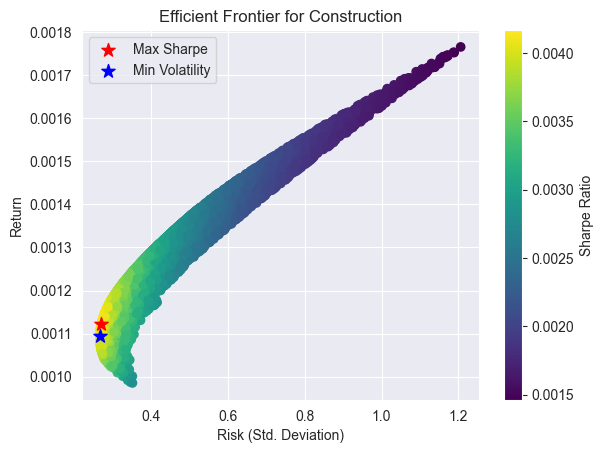

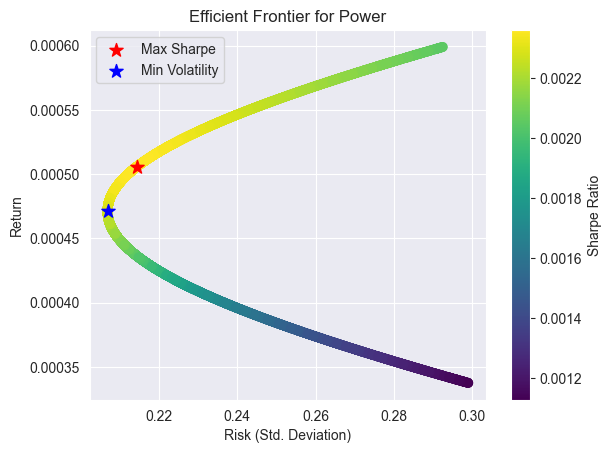

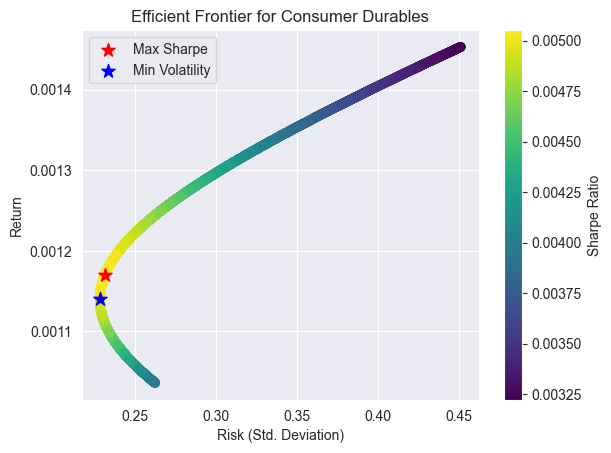

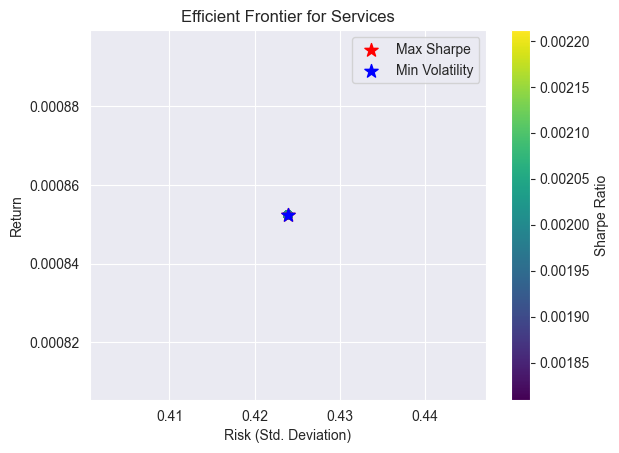

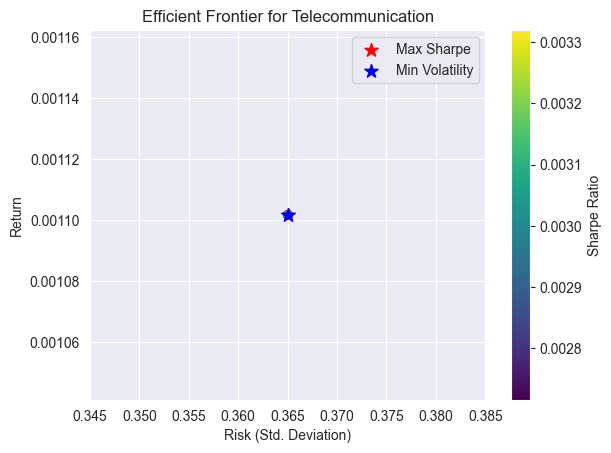

                            Sector  \
0               Financial Services   
1           Information Technology   
2   Automobile and Auto Components   
3       Fast Moving Consumer Goods   
4                       Healthcare   
5       Oil Gas & Consumable Fuels   
6                Metals and Mining   
7                     Construction   
8                            Power   
9                Consumer Durables   
10                        Services   
11               Telecommunication   

    Value at Risk (VaR) at 95% confidence level  Mean Portfolio Risk  
0                                      0.246181             0.521368  
1                                      0.218584             0.253885  
2                                      0.190759             0.392988  
3                                      0.143565             0.165199  
4                                      0.242476             1.078395  
5                                      0.305039             0.535941  
6       

In [49]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return var_value, mean_risk

# Collect VaR and Risk for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, mean_risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Mean Portfolio Risk": mean_risk
        })

# Create DataFrame and display it
results_df = pd.DataFrame(results_list)
print(results_df)


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=1000000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=1000000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record

# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return var_value, mean_risk

# Collect VaR and Risk for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, mean_risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Mean Portfolio Risk": mean_risk
        })

# Create DataFrame and display it
results_df = pd.DataFrame(results_list)
print(results_df)


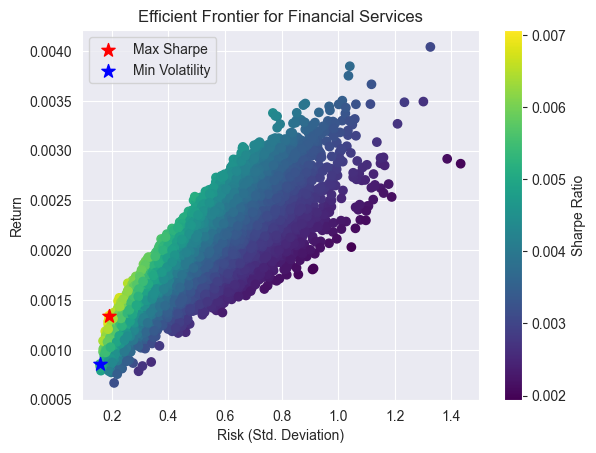

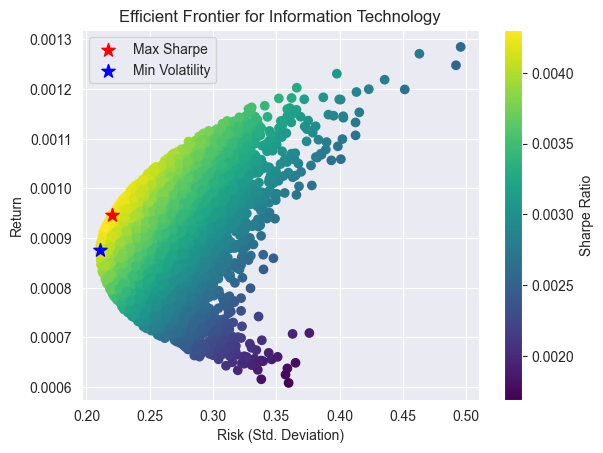

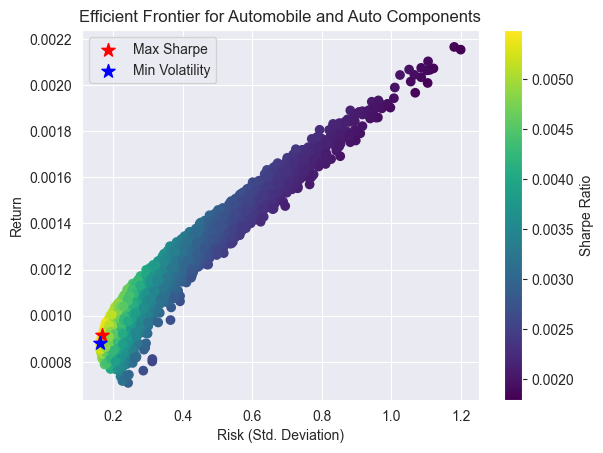

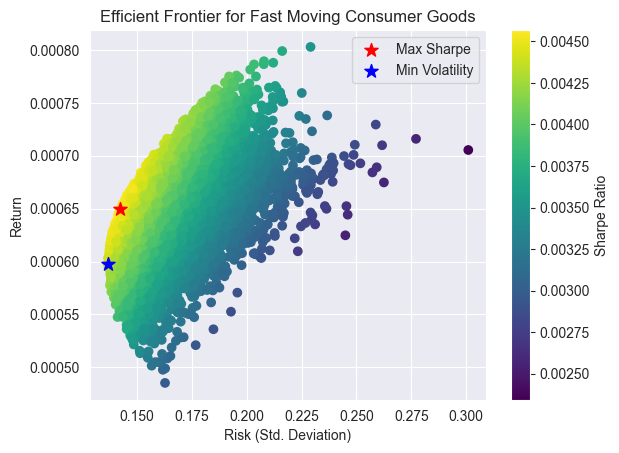

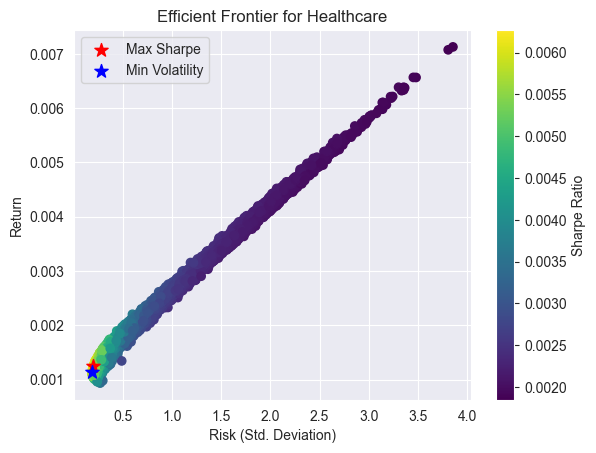

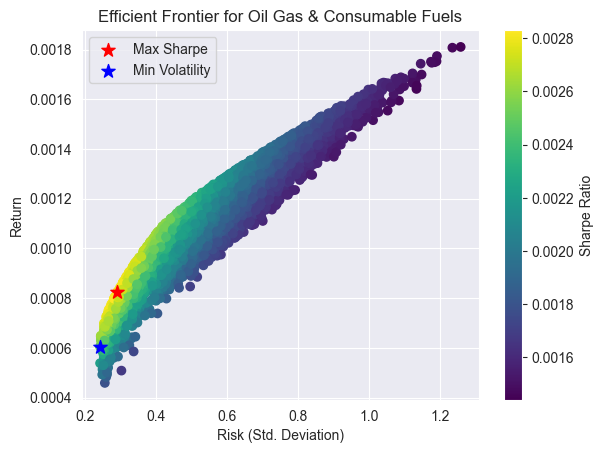

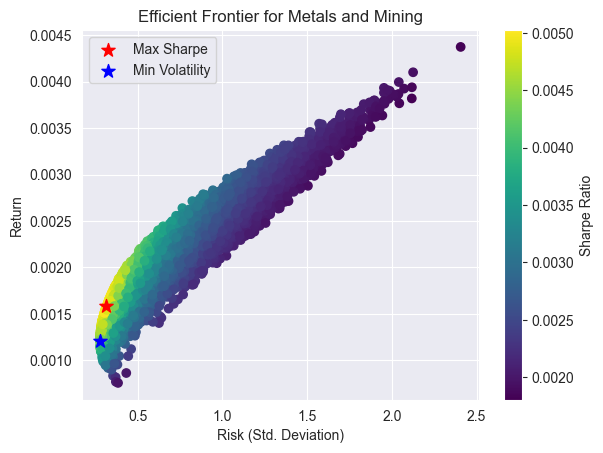

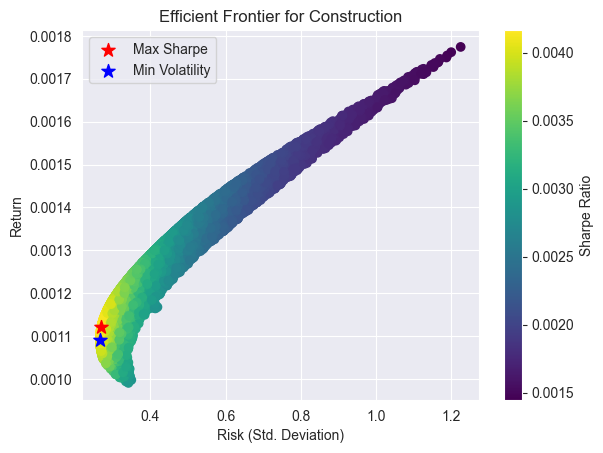

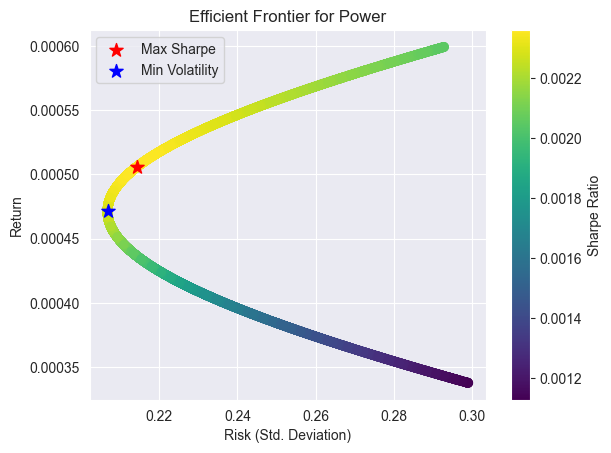

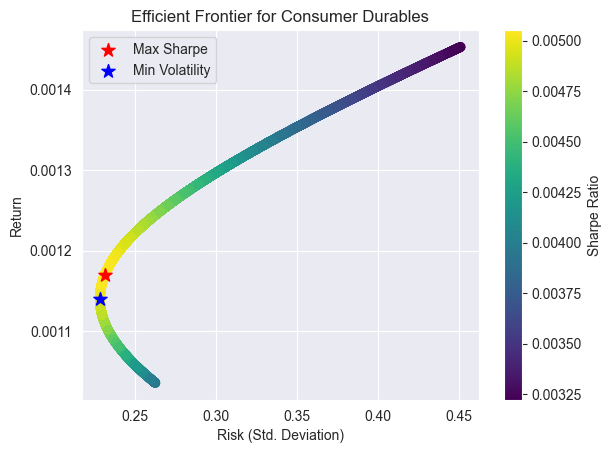

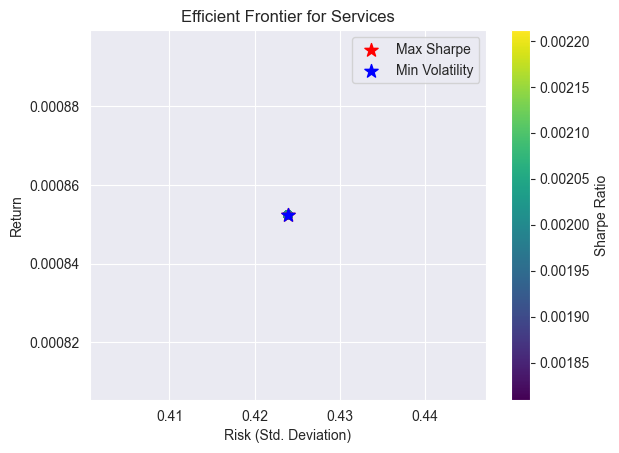

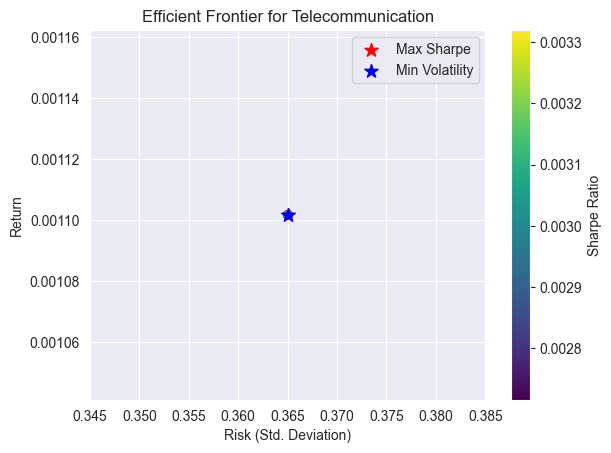

                            Sector  \
0               Financial Services   
1           Information Technology   
2   Automobile and Auto Components   
3       Fast Moving Consumer Goods   
4                       Healthcare   
5       Oil Gas & Consumable Fuels   
6                Metals and Mining   
7                     Construction   
8                            Power   
9                Consumer Durables   
10                        Services   
11               Telecommunication   

    Value at Risk (VaR) at 95% confidence level  Mean Portfolio Risk  
0                                      0.249063             0.520785  
1                                      0.219164             0.254212  
2                                      0.189668             0.391573  
3                                      0.143248             0.165231  
4                                      0.247417             1.083281  
5                                      0.311077             0.542480  
6       

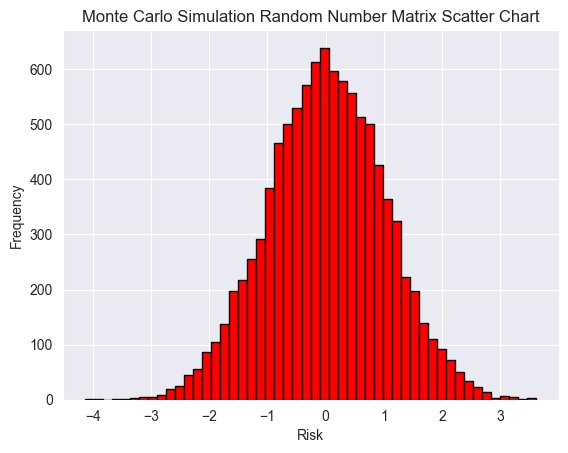

In [56]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define sector portfolios
sector_portfolios = {
    "Financial Services": ['AXISBANK', 'BAJFINANCE', 'HDFCBANK', 'HDFCLIFE', 'ICICIBANK', 
                           'INDUSINDBK', 'KOTAKBANK', 'BAJAJFINSV', 'SBIN', 'SBILIFE'],
    "Information Technology": ['INFY', 'TCS', 'WIPRO', 'TECHM', 'HCLTECH'],
    "Automobile and Auto Components": ['TATAMOTORS', 'BAJAJ-AUTO', 'EICHERMOT', 'M&M', 
                                       'HEROMOTOCO', 'MARUTI'],
    "Fast Moving Consumer Goods": ['ITC', 'BRITANNIA', 'HINDUNILVR', 'NESTLEIND', 'TATACONSUM'],
    "Healthcare": ['APOLLOHOSP', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'SUNPHARMA'],
    "Oil Gas & Consumable Fuels": ['BPCL', 'COALINDIA', 'ONGC', 'RELIANCE'],
    "Metals and Mining": ['ADANIENT', 'HINDALCO', 'JSWSTEEL', 'TATASTEEL'],
    "Construction": ['ULTRACEMCO', 'GRASIM', 'LT'],
    "Power": ['NTPC', 'POWERGRID'],
    "Consumer Durables": ['TITAN', 'ASIANPAINT'],
    "Services": ['ADANIPORTS'],
    "Telecommunication": ['BHARTIARTL']
}

# Directory containing the CSV files
data_directory = "C:/Users/kamis/PycharmProjects/PR/NIFTY50_data_20240901_121017"  # Replace with your directory path
# Function to read CSV files from the directory
def load_data_for_sector(stock_list, directory):
    stock_data = []
    
    for stock in stock_list:
        file_path = os.path.join(directory, f'{stock}.csv')
        if os.path.exists(file_path):
            stock_df = pd.read_csv(file_path)
            stock_df['Returns'] = stock_df['Close'].pct_change()
            stock_data.append(stock_df['Returns'])
        else:
            print(f"File for {stock} not found!")
    
    stock_returns = pd.concat(stock_data, axis=1)
    stock_returns.columns = stock_list
    stock_returns.dropna(inplace=True)
    
    return stock_returns

# Function to calculate portfolio returns and risk
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk







In [ ]:
# Function to calculate negative Sharpe Ratio (used for optimization)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_risk

# Function to perform Monte Carlo simulation and calculate VaR
def monte_carlo_var(stock_returns, num_simulations=10000, confidence_level=0.95):
    portfolio_risks = []
    num_stocks = stock_returns.shape[1]
    
    for _ in range(num_simulations):
        random_weights = np.random.random(num_stocks)
        random_weights /= np.sum(random_weights)
        portfolio_return = np.sum(stock_returns.mean() * random_weights)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(stock_returns.cov() * 252, random_weights)))
        portfolio_risks.append(portfolio_risk)
    
    var_value = np.percentile(portfolio_risks, (1 - confidence_level) * 100)
    return var_value, np.mean(portfolio_risks)

# Efficient Frontier - Function to optimize portfolio for each level of risk
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios=10000):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = portfolio_return / portfolio_risk
        
        results[0,i] = portfolio_return
        results[1,i] = portfolio_risk
        results[2,i] = sharpe_ratio
        
        weights_record.append(weights)
    
    return results, weights_record



# Function to calculate efficient frontier and VaR for a sector
def calculate_efficient_frontier_and_var(sector_name, stock_list, directory):
    stock_returns = load_data_for_sector(stock_list, directory)

    if stock_returns.empty:
        print(f"No data for {sector_name}")
        return None, None
    
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

    # Monte Carlo simulation for VaR
    var_value, mean_risk = monte_carlo_var(stock_returns)

    # Efficient Frontier
    results, weights = optimize_portfolio(mean_returns, cov_matrix)
    
    max_sharpe_idx = np.argmax(results[2])
    min_volatility_idx = np.argmin(results[1])

    # Plot Efficient Frontier
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='r', s=100, label='Max Sharpe')
    plt.scatter(results[1, min_volatility_idx], results[0, min_volatility_idx], marker='*', color='b', s=100, label='Min Volatility')
    plt.title(f'Efficient Frontier for {sector_name}')
    plt.xlabel('Risk (Std. Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    return var_value, mean_risk

# Collect VaR and Risk for each sector
results_list = []

for sector, stocks in sector_portfolios.items():
    var_value, mean_risk = calculate_efficient_frontier_and_var(sector, stocks, data_directory)
    if var_value is not None:
        results_list.append({
            "Sector": sector,
            "Value at Risk (VaR) at 95% confidence level": var_value,
            "Mean Portfolio Risk": mean_risk
        })

# Create DataFrame and display it
results_df = pd.DataFrame(results_list)
print(results_df)

# Additional Monte Carlo simulation for random portfolio risks
num_simulations = 10000
num_bins = 50

# Generate random portfolio risks from a normal distribution
portfolio_risks = np.random.randn(num_simulations)

# Plot histogram
plt.hist(portfolio_risks, bins=num_bins, color='red', edgecolor='black', histtype='bar')

plt.title('Monte Carlo Simulation Random Number Matrix Scatter Chart')
plt.xlabel('Risk')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()